### Import dependencies

In [381]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as path_effects

In [156]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

import os

# from torch.nn import MaxPool2D

torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)

In [6]:
mnist_dataset = datasets.MNIST(root='./data', train=True, 
                               transform=None, target_transform=None, download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [14]:
train_dataset = datasets.MNIST(root='./data', train=True, 
                               transform=None, target_transform=None, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, 
                               transform=None, target_transform=None, download=False)


In [20]:
train_lengths = [int(len(train_dataset)*0.85), int(len(train_dataset)*0.15)]
train_input, train_valid = torch.utils.data.random_split(train_dataset, train_lengths)

In [22]:
test_lengths = [int(len(test_dataset)*0.85), int(len(test_dataset)*0.15)]
test_input, test_valid = torch.utils.data.random_split(test_dataset, test_lengths)

In [23]:
train_input_loader = torch.utils.data.DataLoader(train_input, shuffle=True)
train_valid_loader = torch.utils.data.DataLoader(train_valid, shuffle=True)

test_input_loader = torch.utils.data.DataLoader(test_input, shuffle=True)
test_valid_loader = torch.utils.data.DataLoader(test_valid, shuffle=True)

Naive net

Test set: Average loss: 0.8469, Accuracy: 49454/60000 (82%)



In [479]:


class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [508]:

def train(model,train_loader, optimizer, epoch, log_interval):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        total_loss += loss.item()
    return total_loss


def test(model, test_loader, subset_indices_valid):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    
    total = len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    
    return test_loss, correct, total



## Set parameters

In [481]:
batch_size = 32

epochs = 20
step = 1

test_batch_size = 1000
lr = 1.0
gamma=0.7
no_cuda = False
seed = 1
log_interval = 10
evaluate = False
save_model = True


In [482]:
train_all_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1,
)

In [425]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [436]:
class_counts = {}
for i in range(10):
    class_counts[i] = []

In [437]:
for batch_idx, (data, target) in enumerate(train_dataset):
    class_counts[int(target)].append(batch_idx)

In [454]:
subset_indices_train = np.array([], dtype='int8')
subset_indices_valid = np.array([], dtype='int8')

In [505]:
np.random.seed(0)
for c in class_counts:
    t_size = int(len(class_counts[c])*0.85)
    t = np.random.choice(class_counts[c], size=t_size)
    v = []
    for i in range(len(class_counts[c])):
        if i not in t:
            v.append(int(i))
    
    subset_indices_train = np.concatenate((subset_indices_train, t), axis=None)
    subset_indices_valid = np.concatenate((subset_indices_valid, v), axis=None)

In [456]:
subset_indices_valid

array([   0,    2,    3, ..., 5946, 5947, 5948])

In [483]:
train_dataset = datasets.MNIST('./data', train=True, download=False,
            transform=transforms.Compose([       # Data preprocessing
                transforms.ToTensor(),           # Add data augmentation here
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid)
)


In [484]:
# Load your model [fcNet, ConvNet, Net]
basic_model = ConvNet()

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(basic_model.parameters(), lr=lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

# Training loop
basic_training_losses_over_epochs = []
basic_test_losses_over_epochs = []
for epoch in range(1, epochs + 1):
    loss_ep = train(basic_model, train_loader, optimizer, epoch, log_interval)
    
    test_loss, correct_test_count, total_test_count = test(basic_model, val_loader, subset_indices_valid) 
    
    basic_training_losses_over_epochs.append(loss_ep)
    basic_test_losses_over_epochs.append(test_loss)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(basic_model.state_dict(), "mnist_model2.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308482
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.116527
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.780875
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.570879
Train Epoch: 1 [1280/60000 (3%)]	Loss: 1.116537
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.278446
Train Epoch: 1 [1920/60000 (4%)]	Loss: 1.344341
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.788280
Train Epoch: 1 [2560/60000 (5%)]	Loss: 0.629307
Train Epoch: 1 [2880/60000 (6%)]	Loss: 0.677888
Train Epoch: 1 [3200/60000 (6%)]	Loss: 0.414996
Train Epoch: 1 [3520/60000 (7%)]	Loss: 0.571502
Train Epoch: 1 [3840/60000 (8%)]	Loss: 0.650321
Train Epoch: 1 [4160/60000 (8%)]	Loss: 0.903021
Train Epoch: 1 [4480/60000 (9%)]	Loss: 0.578754
Train Epoch: 1 [4800/60000 (9%)]	Loss: 0.877967
Train Epoch: 1 [5120/60000 (10%)]	Loss: 0.582942
Train Epoch: 1 [5440/60000 (11%)]	Loss: 0.756993
Train Epoch: 1 [5760/60000 (11%)]	Loss: 0.533970
Train Epoch: 1 [6080/60000 (12%)]	Loss: 0.679004
Train Epoch: 1 [6400/60000 (13%)]	Loss: 0.

Train Epoch: 2 [1280/60000 (3%)]	Loss: 0.238482
Train Epoch: 2 [1600/60000 (3%)]	Loss: 0.168759
Train Epoch: 2 [1920/60000 (4%)]	Loss: 0.192355
Train Epoch: 2 [2240/60000 (4%)]	Loss: 0.162484
Train Epoch: 2 [2560/60000 (5%)]	Loss: 0.302181
Train Epoch: 2 [2880/60000 (6%)]	Loss: 0.379095
Train Epoch: 2 [3200/60000 (6%)]	Loss: 0.191843
Train Epoch: 2 [3520/60000 (7%)]	Loss: 0.411574
Train Epoch: 2 [3840/60000 (8%)]	Loss: 0.134551
Train Epoch: 2 [4160/60000 (8%)]	Loss: 0.533961
Train Epoch: 2 [4480/60000 (9%)]	Loss: 0.478182
Train Epoch: 2 [4800/60000 (9%)]	Loss: 0.115606
Train Epoch: 2 [5120/60000 (10%)]	Loss: 0.356959
Train Epoch: 2 [5440/60000 (11%)]	Loss: 0.217884
Train Epoch: 2 [5760/60000 (11%)]	Loss: 0.261441
Train Epoch: 2 [6080/60000 (12%)]	Loss: 0.073346
Train Epoch: 2 [6400/60000 (13%)]	Loss: 0.630473
Train Epoch: 2 [6720/60000 (13%)]	Loss: 0.282147
Train Epoch: 2 [7040/60000 (14%)]	Loss: 0.385878
Train Epoch: 2 [7360/60000 (14%)]	Loss: 0.185215
Train Epoch: 2 [7680/60000 (15%)

Train Epoch: 3 [2560/60000 (5%)]	Loss: 0.359790
Train Epoch: 3 [2880/60000 (6%)]	Loss: 0.159616
Train Epoch: 3 [3200/60000 (6%)]	Loss: 0.232986
Train Epoch: 3 [3520/60000 (7%)]	Loss: 0.410496
Train Epoch: 3 [3840/60000 (8%)]	Loss: 0.228948
Train Epoch: 3 [4160/60000 (8%)]	Loss: 0.286532
Train Epoch: 3 [4480/60000 (9%)]	Loss: 0.314265
Train Epoch: 3 [4800/60000 (9%)]	Loss: 0.130478
Train Epoch: 3 [5120/60000 (10%)]	Loss: 0.237397
Train Epoch: 3 [5440/60000 (11%)]	Loss: 0.407455
Train Epoch: 3 [5760/60000 (11%)]	Loss: 0.207043
Train Epoch: 3 [6080/60000 (12%)]	Loss: 0.286282
Train Epoch: 3 [6400/60000 (13%)]	Loss: 0.390000
Train Epoch: 3 [6720/60000 (13%)]	Loss: 0.497392
Train Epoch: 3 [7040/60000 (14%)]	Loss: 0.370388
Train Epoch: 3 [7360/60000 (14%)]	Loss: 0.053473
Train Epoch: 3 [7680/60000 (15%)]	Loss: 0.228932
Train Epoch: 3 [8000/60000 (16%)]	Loss: 0.056418
Train Epoch: 3 [8320/60000 (16%)]	Loss: 0.266955
Train Epoch: 3 [8640/60000 (17%)]	Loss: 0.161895
Train Epoch: 3 [8960/60000 (

Train Epoch: 4 [3840/60000 (8%)]	Loss: 0.220713
Train Epoch: 4 [4160/60000 (8%)]	Loss: 0.167966
Train Epoch: 4 [4480/60000 (9%)]	Loss: 0.042310
Train Epoch: 4 [4800/60000 (9%)]	Loss: 0.167753
Train Epoch: 4 [5120/60000 (10%)]	Loss: 0.232098
Train Epoch: 4 [5440/60000 (11%)]	Loss: 0.393714
Train Epoch: 4 [5760/60000 (11%)]	Loss: 0.139561
Train Epoch: 4 [6080/60000 (12%)]	Loss: 0.064725
Train Epoch: 4 [6400/60000 (13%)]	Loss: 0.120048
Train Epoch: 4 [6720/60000 (13%)]	Loss: 0.213970
Train Epoch: 4 [7040/60000 (14%)]	Loss: 0.343474
Train Epoch: 4 [7360/60000 (14%)]	Loss: 0.139262
Train Epoch: 4 [7680/60000 (15%)]	Loss: 0.229987
Train Epoch: 4 [8000/60000 (16%)]	Loss: 0.148850
Train Epoch: 4 [8320/60000 (16%)]	Loss: 0.144401
Train Epoch: 4 [8640/60000 (17%)]	Loss: 0.056039
Train Epoch: 4 [8960/60000 (18%)]	Loss: 0.361093
Train Epoch: 4 [9280/60000 (18%)]	Loss: 0.039914
Train Epoch: 4 [9600/60000 (19%)]	Loss: 0.041088
Train Epoch: 4 [9920/60000 (19%)]	Loss: 0.061431
Train Epoch: 4 [10240/60

Train Epoch: 5 [5120/60000 (10%)]	Loss: 0.164362
Train Epoch: 5 [5440/60000 (11%)]	Loss: 0.195379
Train Epoch: 5 [5760/60000 (11%)]	Loss: 0.362821
Train Epoch: 5 [6080/60000 (12%)]	Loss: 0.045673
Train Epoch: 5 [6400/60000 (13%)]	Loss: 0.085240
Train Epoch: 5 [6720/60000 (13%)]	Loss: 0.069549
Train Epoch: 5 [7040/60000 (14%)]	Loss: 0.155117
Train Epoch: 5 [7360/60000 (14%)]	Loss: 0.238434
Train Epoch: 5 [7680/60000 (15%)]	Loss: 0.036844
Train Epoch: 5 [8000/60000 (16%)]	Loss: 0.401222
Train Epoch: 5 [8320/60000 (16%)]	Loss: 0.032807
Train Epoch: 5 [8640/60000 (17%)]	Loss: 0.042860
Train Epoch: 5 [8960/60000 (18%)]	Loss: 0.103190
Train Epoch: 5 [9280/60000 (18%)]	Loss: 0.334678
Train Epoch: 5 [9600/60000 (19%)]	Loss: 0.495916
Train Epoch: 5 [9920/60000 (19%)]	Loss: 0.293983
Train Epoch: 5 [10240/60000 (20%)]	Loss: 0.186560
Train Epoch: 5 [10560/60000 (21%)]	Loss: 0.091258
Train Epoch: 5 [10880/60000 (21%)]	Loss: 0.287861
Train Epoch: 5 [11200/60000 (22%)]	Loss: 0.299150
Train Epoch: 5 [

Train Epoch: 6 [6400/60000 (13%)]	Loss: 0.223882
Train Epoch: 6 [6720/60000 (13%)]	Loss: 0.148754
Train Epoch: 6 [7040/60000 (14%)]	Loss: 0.348018
Train Epoch: 6 [7360/60000 (14%)]	Loss: 0.266085
Train Epoch: 6 [7680/60000 (15%)]	Loss: 0.292789
Train Epoch: 6 [8000/60000 (16%)]	Loss: 0.105299
Train Epoch: 6 [8320/60000 (16%)]	Loss: 0.107200
Train Epoch: 6 [8640/60000 (17%)]	Loss: 0.095316
Train Epoch: 6 [8960/60000 (18%)]	Loss: 0.288923
Train Epoch: 6 [9280/60000 (18%)]	Loss: 0.147470
Train Epoch: 6 [9600/60000 (19%)]	Loss: 0.227921
Train Epoch: 6 [9920/60000 (19%)]	Loss: 0.238313
Train Epoch: 6 [10240/60000 (20%)]	Loss: 0.236126
Train Epoch: 6 [10560/60000 (21%)]	Loss: 0.061934
Train Epoch: 6 [10880/60000 (21%)]	Loss: 0.138309
Train Epoch: 6 [11200/60000 (22%)]	Loss: 0.209780
Train Epoch: 6 [11520/60000 (23%)]	Loss: 0.103067
Train Epoch: 6 [11840/60000 (23%)]	Loss: 0.078698
Train Epoch: 6 [12160/60000 (24%)]	Loss: 0.163325
Train Epoch: 6 [12480/60000 (24%)]	Loss: 0.322461
Train Epoch:

Train Epoch: 7 [7680/60000 (15%)]	Loss: 0.156105
Train Epoch: 7 [8000/60000 (16%)]	Loss: 0.343349
Train Epoch: 7 [8320/60000 (16%)]	Loss: 0.334531
Train Epoch: 7 [8640/60000 (17%)]	Loss: 0.092007
Train Epoch: 7 [8960/60000 (18%)]	Loss: 0.254034
Train Epoch: 7 [9280/60000 (18%)]	Loss: 0.429711
Train Epoch: 7 [9600/60000 (19%)]	Loss: 0.133290
Train Epoch: 7 [9920/60000 (19%)]	Loss: 0.116255
Train Epoch: 7 [10240/60000 (20%)]	Loss: 0.183581
Train Epoch: 7 [10560/60000 (21%)]	Loss: 0.327314
Train Epoch: 7 [10880/60000 (21%)]	Loss: 0.287204
Train Epoch: 7 [11200/60000 (22%)]	Loss: 0.447247
Train Epoch: 7 [11520/60000 (23%)]	Loss: 0.181348
Train Epoch: 7 [11840/60000 (23%)]	Loss: 0.285470
Train Epoch: 7 [12160/60000 (24%)]	Loss: 0.144338
Train Epoch: 7 [12480/60000 (24%)]	Loss: 0.061127
Train Epoch: 7 [12800/60000 (25%)]	Loss: 0.355896
Train Epoch: 7 [13120/60000 (26%)]	Loss: 0.020488
Train Epoch: 7 [13440/60000 (26%)]	Loss: 0.395061
Train Epoch: 7 [13760/60000 (27%)]	Loss: 0.051161
Train Ep

Train Epoch: 8 [8960/60000 (18%)]	Loss: 0.153854
Train Epoch: 8 [9280/60000 (18%)]	Loss: 0.033445
Train Epoch: 8 [9600/60000 (19%)]	Loss: 0.048154
Train Epoch: 8 [9920/60000 (19%)]	Loss: 0.251058
Train Epoch: 8 [10240/60000 (20%)]	Loss: 0.059393
Train Epoch: 8 [10560/60000 (21%)]	Loss: 0.338273
Train Epoch: 8 [10880/60000 (21%)]	Loss: 0.720420
Train Epoch: 8 [11200/60000 (22%)]	Loss: 0.045045
Train Epoch: 8 [11520/60000 (23%)]	Loss: 0.547594
Train Epoch: 8 [11840/60000 (23%)]	Loss: 0.191957
Train Epoch: 8 [12160/60000 (24%)]	Loss: 0.309372
Train Epoch: 8 [12480/60000 (24%)]	Loss: 0.466445
Train Epoch: 8 [12800/60000 (25%)]	Loss: 0.412723
Train Epoch: 8 [13120/60000 (26%)]	Loss: 0.060769
Train Epoch: 8 [13440/60000 (26%)]	Loss: 0.076770
Train Epoch: 8 [13760/60000 (27%)]	Loss: 0.159133
Train Epoch: 8 [14080/60000 (28%)]	Loss: 0.134085
Train Epoch: 8 [14400/60000 (28%)]	Loss: 0.469240
Train Epoch: 8 [14720/60000 (29%)]	Loss: 0.025749
Train Epoch: 8 [15040/60000 (29%)]	Loss: 0.036977
Trai

Train Epoch: 9 [10240/60000 (20%)]	Loss: 0.556281
Train Epoch: 9 [10560/60000 (21%)]	Loss: 0.460428
Train Epoch: 9 [10880/60000 (21%)]	Loss: 0.168711
Train Epoch: 9 [11200/60000 (22%)]	Loss: 0.039718
Train Epoch: 9 [11520/60000 (23%)]	Loss: 0.149140
Train Epoch: 9 [11840/60000 (23%)]	Loss: 0.148041
Train Epoch: 9 [12160/60000 (24%)]	Loss: 0.260231
Train Epoch: 9 [12480/60000 (24%)]	Loss: 0.912415
Train Epoch: 9 [12800/60000 (25%)]	Loss: 0.084693
Train Epoch: 9 [13120/60000 (26%)]	Loss: 0.354086
Train Epoch: 9 [13440/60000 (26%)]	Loss: 0.130564
Train Epoch: 9 [13760/60000 (27%)]	Loss: 0.307456
Train Epoch: 9 [14080/60000 (28%)]	Loss: 0.556126
Train Epoch: 9 [14400/60000 (28%)]	Loss: 0.191436
Train Epoch: 9 [14720/60000 (29%)]	Loss: 0.280991
Train Epoch: 9 [15040/60000 (29%)]	Loss: 0.334098
Train Epoch: 9 [15360/60000 (30%)]	Loss: 0.104107
Train Epoch: 9 [15680/60000 (31%)]	Loss: 0.120897
Train Epoch: 9 [16000/60000 (31%)]	Loss: 0.072474
Train Epoch: 9 [16320/60000 (32%)]	Loss: 0.216031


Train Epoch: 10 [11520/60000 (23%)]	Loss: 0.150669
Train Epoch: 10 [11840/60000 (23%)]	Loss: 0.159954
Train Epoch: 10 [12160/60000 (24%)]	Loss: 0.129786
Train Epoch: 10 [12480/60000 (24%)]	Loss: 0.304668
Train Epoch: 10 [12800/60000 (25%)]	Loss: 0.354499
Train Epoch: 10 [13120/60000 (26%)]	Loss: 0.254527
Train Epoch: 10 [13440/60000 (26%)]	Loss: 0.487031
Train Epoch: 10 [13760/60000 (27%)]	Loss: 0.100794
Train Epoch: 10 [14080/60000 (28%)]	Loss: 0.029502
Train Epoch: 10 [14400/60000 (28%)]	Loss: 0.058662
Train Epoch: 10 [14720/60000 (29%)]	Loss: 0.110435
Train Epoch: 10 [15040/60000 (29%)]	Loss: 0.051173
Train Epoch: 10 [15360/60000 (30%)]	Loss: 0.065982
Train Epoch: 10 [15680/60000 (31%)]	Loss: 0.078639
Train Epoch: 10 [16000/60000 (31%)]	Loss: 0.358493
Train Epoch: 10 [16320/60000 (32%)]	Loss: 0.070202
Train Epoch: 10 [16640/60000 (33%)]	Loss: 0.020574
Train Epoch: 10 [16960/60000 (33%)]	Loss: 0.163571
Train Epoch: 10 [17280/60000 (34%)]	Loss: 0.123588
Train Epoch: 10 [17600/60000 (3

Train Epoch: 11 [12160/60000 (24%)]	Loss: 0.341189
Train Epoch: 11 [12480/60000 (24%)]	Loss: 0.094463
Train Epoch: 11 [12800/60000 (25%)]	Loss: 0.068474
Train Epoch: 11 [13120/60000 (26%)]	Loss: 0.350270
Train Epoch: 11 [13440/60000 (26%)]	Loss: 0.061213
Train Epoch: 11 [13760/60000 (27%)]	Loss: 0.087140
Train Epoch: 11 [14080/60000 (28%)]	Loss: 0.175929
Train Epoch: 11 [14400/60000 (28%)]	Loss: 0.005961
Train Epoch: 11 [14720/60000 (29%)]	Loss: 0.123562
Train Epoch: 11 [15040/60000 (29%)]	Loss: 0.172008
Train Epoch: 11 [15360/60000 (30%)]	Loss: 0.016612
Train Epoch: 11 [15680/60000 (31%)]	Loss: 0.388643
Train Epoch: 11 [16000/60000 (31%)]	Loss: 0.255693
Train Epoch: 11 [16320/60000 (32%)]	Loss: 0.351921
Train Epoch: 11 [16640/60000 (33%)]	Loss: 0.380395
Train Epoch: 11 [16960/60000 (33%)]	Loss: 0.513705
Train Epoch: 11 [17280/60000 (34%)]	Loss: 0.036408
Train Epoch: 11 [17600/60000 (35%)]	Loss: 0.104593
Train Epoch: 11 [17920/60000 (35%)]	Loss: 0.045207
Train Epoch: 11 [18240/60000 (3

Train Epoch: 12 [12800/60000 (25%)]	Loss: 0.047251
Train Epoch: 12 [13120/60000 (26%)]	Loss: 0.137062
Train Epoch: 12 [13440/60000 (26%)]	Loss: 0.009156
Train Epoch: 12 [13760/60000 (27%)]	Loss: 0.136262
Train Epoch: 12 [14080/60000 (28%)]	Loss: 0.120882
Train Epoch: 12 [14400/60000 (28%)]	Loss: 0.120835
Train Epoch: 12 [14720/60000 (29%)]	Loss: 0.136991
Train Epoch: 12 [15040/60000 (29%)]	Loss: 0.413081
Train Epoch: 12 [15360/60000 (30%)]	Loss: 0.164132
Train Epoch: 12 [15680/60000 (31%)]	Loss: 0.075875
Train Epoch: 12 [16000/60000 (31%)]	Loss: 0.296354
Train Epoch: 12 [16320/60000 (32%)]	Loss: 0.034192
Train Epoch: 12 [16640/60000 (33%)]	Loss: 0.333681
Train Epoch: 12 [16960/60000 (33%)]	Loss: 0.206776
Train Epoch: 12 [17280/60000 (34%)]	Loss: 0.104737
Train Epoch: 12 [17600/60000 (35%)]	Loss: 0.126242
Train Epoch: 12 [17920/60000 (35%)]	Loss: 0.017012
Train Epoch: 12 [18240/60000 (36%)]	Loss: 0.349276
Train Epoch: 12 [18560/60000 (36%)]	Loss: 0.551727
Train Epoch: 12 [18880/60000 (3

Train Epoch: 13 [13440/60000 (26%)]	Loss: 0.069101
Train Epoch: 13 [13760/60000 (27%)]	Loss: 0.096639
Train Epoch: 13 [14080/60000 (28%)]	Loss: 0.091374
Train Epoch: 13 [14400/60000 (28%)]	Loss: 0.344003
Train Epoch: 13 [14720/60000 (29%)]	Loss: 0.085557
Train Epoch: 13 [15040/60000 (29%)]	Loss: 0.326983
Train Epoch: 13 [15360/60000 (30%)]	Loss: 0.304867
Train Epoch: 13 [15680/60000 (31%)]	Loss: 0.094327
Train Epoch: 13 [16000/60000 (31%)]	Loss: 0.126030
Train Epoch: 13 [16320/60000 (32%)]	Loss: 0.224529
Train Epoch: 13 [16640/60000 (33%)]	Loss: 0.100707
Train Epoch: 13 [16960/60000 (33%)]	Loss: 0.141700
Train Epoch: 13 [17280/60000 (34%)]	Loss: 0.125667
Train Epoch: 13 [17600/60000 (35%)]	Loss: 0.048397
Train Epoch: 13 [17920/60000 (35%)]	Loss: 0.281510
Train Epoch: 13 [18240/60000 (36%)]	Loss: 0.149950
Train Epoch: 13 [18560/60000 (36%)]	Loss: 0.479398
Train Epoch: 13 [18880/60000 (37%)]	Loss: 0.057012
Train Epoch: 13 [19200/60000 (38%)]	Loss: 0.215734
Train Epoch: 13 [19520/60000 (3

Train Epoch: 14 [14080/60000 (28%)]	Loss: 0.141826
Train Epoch: 14 [14400/60000 (28%)]	Loss: 0.087230
Train Epoch: 14 [14720/60000 (29%)]	Loss: 0.040328
Train Epoch: 14 [15040/60000 (29%)]	Loss: 0.067540
Train Epoch: 14 [15360/60000 (30%)]	Loss: 0.276973
Train Epoch: 14 [15680/60000 (31%)]	Loss: 0.354610
Train Epoch: 14 [16000/60000 (31%)]	Loss: 0.037869
Train Epoch: 14 [16320/60000 (32%)]	Loss: 0.254194
Train Epoch: 14 [16640/60000 (33%)]	Loss: 0.304445
Train Epoch: 14 [16960/60000 (33%)]	Loss: 0.150591
Train Epoch: 14 [17280/60000 (34%)]	Loss: 0.042132
Train Epoch: 14 [17600/60000 (35%)]	Loss: 0.093250
Train Epoch: 14 [17920/60000 (35%)]	Loss: 0.223265
Train Epoch: 14 [18240/60000 (36%)]	Loss: 0.025829
Train Epoch: 14 [18560/60000 (36%)]	Loss: 0.156927
Train Epoch: 14 [18880/60000 (37%)]	Loss: 0.025738
Train Epoch: 14 [19200/60000 (38%)]	Loss: 0.317182
Train Epoch: 14 [19520/60000 (38%)]	Loss: 0.354488
Train Epoch: 14 [19840/60000 (39%)]	Loss: 0.289626
Train Epoch: 14 [20160/60000 (4

Train Epoch: 15 [14720/60000 (29%)]	Loss: 0.131577
Train Epoch: 15 [15040/60000 (29%)]	Loss: 0.258032
Train Epoch: 15 [15360/60000 (30%)]	Loss: 0.217605
Train Epoch: 15 [15680/60000 (31%)]	Loss: 0.170446
Train Epoch: 15 [16000/60000 (31%)]	Loss: 0.472771
Train Epoch: 15 [16320/60000 (32%)]	Loss: 0.100951
Train Epoch: 15 [16640/60000 (33%)]	Loss: 0.030267
Train Epoch: 15 [16960/60000 (33%)]	Loss: 0.024359
Train Epoch: 15 [17280/60000 (34%)]	Loss: 0.229434
Train Epoch: 15 [17600/60000 (35%)]	Loss: 0.263409
Train Epoch: 15 [17920/60000 (35%)]	Loss: 0.067241
Train Epoch: 15 [18240/60000 (36%)]	Loss: 0.248076
Train Epoch: 15 [18560/60000 (36%)]	Loss: 0.243794
Train Epoch: 15 [18880/60000 (37%)]	Loss: 0.027455
Train Epoch: 15 [19200/60000 (38%)]	Loss: 0.226588
Train Epoch: 15 [19520/60000 (38%)]	Loss: 0.202361
Train Epoch: 15 [19840/60000 (39%)]	Loss: 0.155702
Train Epoch: 15 [20160/60000 (40%)]	Loss: 0.124721
Train Epoch: 15 [20480/60000 (40%)]	Loss: 0.074837
Train Epoch: 15 [20800/60000 (4

Train Epoch: 16 [15360/60000 (30%)]	Loss: 0.003958
Train Epoch: 16 [15680/60000 (31%)]	Loss: 0.205068
Train Epoch: 16 [16000/60000 (31%)]	Loss: 0.332384
Train Epoch: 16 [16320/60000 (32%)]	Loss: 0.014076
Train Epoch: 16 [16640/60000 (33%)]	Loss: 0.018288
Train Epoch: 16 [16960/60000 (33%)]	Loss: 0.068671
Train Epoch: 16 [17280/60000 (34%)]	Loss: 0.758332
Train Epoch: 16 [17600/60000 (35%)]	Loss: 0.091960
Train Epoch: 16 [17920/60000 (35%)]	Loss: 0.213353
Train Epoch: 16 [18240/60000 (36%)]	Loss: 0.260780
Train Epoch: 16 [18560/60000 (36%)]	Loss: 0.399356
Train Epoch: 16 [18880/60000 (37%)]	Loss: 0.041956
Train Epoch: 16 [19200/60000 (38%)]	Loss: 0.247778
Train Epoch: 16 [19520/60000 (38%)]	Loss: 0.110058
Train Epoch: 16 [19840/60000 (39%)]	Loss: 0.144501
Train Epoch: 16 [20160/60000 (40%)]	Loss: 0.190971
Train Epoch: 16 [20480/60000 (40%)]	Loss: 0.062212
Train Epoch: 16 [20800/60000 (41%)]	Loss: 0.157457
Train Epoch: 16 [21120/60000 (41%)]	Loss: 0.125896
Train Epoch: 16 [21440/60000 (4

Train Epoch: 17 [16000/60000 (31%)]	Loss: 0.158703
Train Epoch: 17 [16320/60000 (32%)]	Loss: 0.172351
Train Epoch: 17 [16640/60000 (33%)]	Loss: 0.018901
Train Epoch: 17 [16960/60000 (33%)]	Loss: 0.073621
Train Epoch: 17 [17280/60000 (34%)]	Loss: 0.111694
Train Epoch: 17 [17600/60000 (35%)]	Loss: 0.229104
Train Epoch: 17 [17920/60000 (35%)]	Loss: 0.006657
Train Epoch: 17 [18240/60000 (36%)]	Loss: 0.435070
Train Epoch: 17 [18560/60000 (36%)]	Loss: 0.038376
Train Epoch: 17 [18880/60000 (37%)]	Loss: 0.028535
Train Epoch: 17 [19200/60000 (38%)]	Loss: 0.109634
Train Epoch: 17 [19520/60000 (38%)]	Loss: 0.114215
Train Epoch: 17 [19840/60000 (39%)]	Loss: 0.028787
Train Epoch: 17 [20160/60000 (40%)]	Loss: 0.042452
Train Epoch: 17 [20480/60000 (40%)]	Loss: 0.316973
Train Epoch: 17 [20800/60000 (41%)]	Loss: 0.227117
Train Epoch: 17 [21120/60000 (41%)]	Loss: 0.109807
Train Epoch: 17 [21440/60000 (42%)]	Loss: 0.108078
Train Epoch: 17 [21760/60000 (43%)]	Loss: 0.105654
Train Epoch: 17 [22080/60000 (4

Train Epoch: 18 [16640/60000 (33%)]	Loss: 0.058927
Train Epoch: 18 [16960/60000 (33%)]	Loss: 0.256487
Train Epoch: 18 [17280/60000 (34%)]	Loss: 0.051917
Train Epoch: 18 [17600/60000 (35%)]	Loss: 0.048448
Train Epoch: 18 [17920/60000 (35%)]	Loss: 0.012641
Train Epoch: 18 [18240/60000 (36%)]	Loss: 0.139846
Train Epoch: 18 [18560/60000 (36%)]	Loss: 0.286143
Train Epoch: 18 [18880/60000 (37%)]	Loss: 0.141534
Train Epoch: 18 [19200/60000 (38%)]	Loss: 0.213423
Train Epoch: 18 [19520/60000 (38%)]	Loss: 0.409083
Train Epoch: 18 [19840/60000 (39%)]	Loss: 0.094987
Train Epoch: 18 [20160/60000 (40%)]	Loss: 0.065904
Train Epoch: 18 [20480/60000 (40%)]	Loss: 0.122093
Train Epoch: 18 [20800/60000 (41%)]	Loss: 0.349850
Train Epoch: 18 [21120/60000 (41%)]	Loss: 0.115790
Train Epoch: 18 [21440/60000 (42%)]	Loss: 0.241541
Train Epoch: 18 [21760/60000 (43%)]	Loss: 0.420568
Train Epoch: 18 [22080/60000 (43%)]	Loss: 0.102713
Train Epoch: 18 [22400/60000 (44%)]	Loss: 0.125678
Train Epoch: 18 [22720/60000 (4

Train Epoch: 19 [17280/60000 (34%)]	Loss: 0.312414
Train Epoch: 19 [17600/60000 (35%)]	Loss: 0.161964
Train Epoch: 19 [17920/60000 (35%)]	Loss: 0.125060
Train Epoch: 19 [18240/60000 (36%)]	Loss: 0.186267
Train Epoch: 19 [18560/60000 (36%)]	Loss: 0.244957
Train Epoch: 19 [18880/60000 (37%)]	Loss: 0.150769
Train Epoch: 19 [19200/60000 (38%)]	Loss: 0.048809
Train Epoch: 19 [19520/60000 (38%)]	Loss: 0.244009
Train Epoch: 19 [19840/60000 (39%)]	Loss: 0.122130
Train Epoch: 19 [20160/60000 (40%)]	Loss: 0.049664
Train Epoch: 19 [20480/60000 (40%)]	Loss: 0.105616
Train Epoch: 19 [20800/60000 (41%)]	Loss: 0.099441
Train Epoch: 19 [21120/60000 (41%)]	Loss: 0.150942
Train Epoch: 19 [21440/60000 (42%)]	Loss: 0.385756
Train Epoch: 19 [21760/60000 (43%)]	Loss: 0.014010
Train Epoch: 19 [22080/60000 (43%)]	Loss: 0.133158
Train Epoch: 19 [22400/60000 (44%)]	Loss: 0.265644
Train Epoch: 19 [22720/60000 (45%)]	Loss: 0.215787
Train Epoch: 19 [23040/60000 (45%)]	Loss: 0.173031
Train Epoch: 19 [23360/60000 (4

Train Epoch: 20 [17920/60000 (35%)]	Loss: 0.160727
Train Epoch: 20 [18240/60000 (36%)]	Loss: 0.104859
Train Epoch: 20 [18560/60000 (36%)]	Loss: 0.021258
Train Epoch: 20 [18880/60000 (37%)]	Loss: 0.193208
Train Epoch: 20 [19200/60000 (38%)]	Loss: 0.054459
Train Epoch: 20 [19520/60000 (38%)]	Loss: 0.223386
Train Epoch: 20 [19840/60000 (39%)]	Loss: 0.032533
Train Epoch: 20 [20160/60000 (40%)]	Loss: 0.126806
Train Epoch: 20 [20480/60000 (40%)]	Loss: 0.075665
Train Epoch: 20 [20800/60000 (41%)]	Loss: 0.206147
Train Epoch: 20 [21120/60000 (41%)]	Loss: 0.390502
Train Epoch: 20 [21440/60000 (42%)]	Loss: 0.036660
Train Epoch: 20 [21760/60000 (43%)]	Loss: 0.389474
Train Epoch: 20 [22080/60000 (43%)]	Loss: 0.194956
Train Epoch: 20 [22400/60000 (44%)]	Loss: 0.106844
Train Epoch: 20 [22720/60000 (45%)]	Loss: 0.140714
Train Epoch: 20 [23040/60000 (45%)]	Loss: 0.170274
Train Epoch: 20 [23360/60000 (46%)]	Loss: 0.110827
Train Epoch: 20 [23680/60000 (46%)]	Loss: 0.060148
Train Epoch: 20 [24000/60000 (4

In [511]:
test(basic_model, train_loader, subset_indices_valid) 


Test set: Average loss: 0.0607, Accuracy: 49970/60000 (83%)



(0.060738561400522785, 49970, 60000)

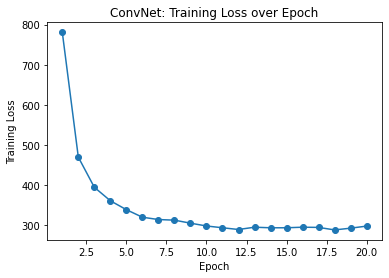

In [514]:
x = list(range(1, epochs + 1))
y = basic_training_losses_over_epochs
plt.plot(x, y)
plt.scatter(x, y)
plt.title("ConvNet: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

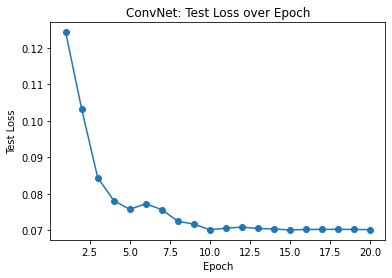

In [515]:
# test(basic_model, train_loader, subset_indices_valid) 
# test(basic_model, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = basic_test_losses_over_epochs
plt.plot(x, y)
plt.scatter(x, y)
plt.title("ConvNet: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

ConvNet Results:
Test set: Average loss: 0.1231, Accuracy: 114539/116561 (98%)

## Augment Data

In [486]:
gaussian_kernel = np.load('gaussian-kernel.npy')

In [487]:
box_kernel = np.ones(gaussian_kernel.shape)

In [488]:
print(gaussian_kernel)

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


In [489]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [490]:
def convolution(img, kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    kernel_size = kernel.shape[0]
    pad_amount = int(kernel_size/2)
    gaussian_convolved_img = np.zeros(img.shape)
    zero_padded = np.pad(img[0, :,:], pad_amount, pad_with, padder=0)
    for r in range(pad_amount, MAX_ROWS+pad_amount):
        for c in range(pad_amount, MAX_COLS+pad_amount):
#             print("r-pad_amount", r-pad_amount)
#             print("r-pad_amount+kernel_size", r-pad_amount+kernel_size)
            conv = np.multiply(zero_padded[r-pad_amount:r-pad_amount+kernel_size, c-pad_amount:c-pad_amount+kernel_size],kernel)
            conv = np.sum(conv)
            gaussian_convolved_img[0, r-pad_amount, c-pad_amount] = (conv)
    return gaussian_convolved_img

In [491]:
augmented_train_dataset = datasets.MNIST('./data', train=True, download=False,
            transform=transforms.Compose([       # Data preprocessing
                transforms.ToTensor(),           # Add data augmentation here
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

In [492]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [493]:

for batch_idx, (data, target) in enumerate(train_loader):
    new_data = []
    new_target = []
    data, target = data, target
    for i in range(len(data)):
        input_x = data[i]
        gaussian_input = convolution(input_x, gaussian_kernel)
        gaussian_input = torch.FloatTensor(gaussian_input)
        new_data.append(input_x)
        new_data.append(gaussian_input)
        new_target.append(target[i])
        new_target.append(target[i])
    
    data = torch.stack(new_data, 0) 
    target = torch.tensor(new_target)

In [494]:
def augmented_train(model,train_loader, optimizer, epoch, log_interval):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    total_loss = 0
    model.train()   # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        new_data = []
        new_target = []
        data, target = data, target
        for i in range(len(data)):
            input_x = data[i]
            gaussian_input = convolution(input_x, box_kernel)
            gaussian_input = torch.FloatTensor(gaussian_input)
            new_data.append(input_x)
            new_data.append(gaussian_input)
            new_target.append(target[i])
            new_target.append(target[i])

        data = torch.stack(new_data, 0) 
        target = torch.tensor(new_target)
    
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        total_loss += loss.item()
    return total_loss

In [495]:
# Load your model [fcNet, ConvNet, Net]
aug_basic_model = ConvNet()

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(aug_basic_model.parameters(), lr=lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)
augmented_basic_training_losses_over_epochs = []
augmented_basic_test_losses_over_epochs = []
# Training loop
for epoch in range(1, epochs + 1):
    loss_ep = train(aug_basic_model, train_loader, optimizer, epoch, log_interval)
    test_loss, _, _ = test(aug_basic_model, val_loader, subset_indices_valid) 
    
    augmented_basic_training_losses_over_epochs.append(loss_ep)
    augmented_basic_test_losses_over_epochs.append(test_loss)
    
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(aug_basic_model.state_dict(), "mnist_model2_aug2.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323024
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.103669
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.798738
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.593143
Train Epoch: 1 [1280/60000 (3%)]	Loss: 1.359967
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.067862
Train Epoch: 1 [1920/60000 (4%)]	Loss: 0.784258
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.023206
Train Epoch: 1 [2560/60000 (5%)]	Loss: 1.057389
Train Epoch: 1 [2880/60000 (6%)]	Loss: 0.927243
Train Epoch: 1 [3200/60000 (6%)]	Loss: 0.778197
Train Epoch: 1 [3520/60000 (7%)]	Loss: 0.421101
Train Epoch: 1 [3840/60000 (8%)]	Loss: 1.193863
Train Epoch: 1 [4160/60000 (8%)]	Loss: 0.811233
Train Epoch: 1 [4480/60000 (9%)]	Loss: 1.146762
Train Epoch: 1 [4800/60000 (9%)]	Loss: 1.056234
Train Epoch: 1 [5120/60000 (10%)]	Loss: 0.493090
Train Epoch: 1 [5440/60000 (11%)]	Loss: 0.488051
Train Epoch: 1 [5760/60000 (11%)]	Loss: 0.601663
Train Epoch: 1 [6080/60000 (12%)]	Loss: 0.373641
Train Epoch: 1 [6400/60000 (13%)]	Loss: 0.

Train Epoch: 2 [1280/60000 (3%)]	Loss: 0.177380
Train Epoch: 2 [1600/60000 (3%)]	Loss: 0.170577
Train Epoch: 2 [1920/60000 (4%)]	Loss: 0.618832
Train Epoch: 2 [2240/60000 (4%)]	Loss: 0.341189
Train Epoch: 2 [2560/60000 (5%)]	Loss: 0.340506
Train Epoch: 2 [2880/60000 (6%)]	Loss: 0.934956
Train Epoch: 2 [3200/60000 (6%)]	Loss: 0.346087
Train Epoch: 2 [3520/60000 (7%)]	Loss: 0.170688
Train Epoch: 2 [3840/60000 (8%)]	Loss: 0.399524
Train Epoch: 2 [4160/60000 (8%)]	Loss: 0.274284
Train Epoch: 2 [4480/60000 (9%)]	Loss: 0.546936
Train Epoch: 2 [4800/60000 (9%)]	Loss: 0.374860
Train Epoch: 2 [5120/60000 (10%)]	Loss: 0.449896
Train Epoch: 2 [5440/60000 (11%)]	Loss: 0.234046
Train Epoch: 2 [5760/60000 (11%)]	Loss: 0.131202
Train Epoch: 2 [6080/60000 (12%)]	Loss: 0.278492
Train Epoch: 2 [6400/60000 (13%)]	Loss: 0.340170
Train Epoch: 2 [6720/60000 (13%)]	Loss: 0.077948
Train Epoch: 2 [7040/60000 (14%)]	Loss: 0.493082
Train Epoch: 2 [7360/60000 (14%)]	Loss: 0.318399
Train Epoch: 2 [7680/60000 (15%)

Train Epoch: 3 [2560/60000 (5%)]	Loss: 0.155579
Train Epoch: 3 [2880/60000 (6%)]	Loss: 0.648156
Train Epoch: 3 [3200/60000 (6%)]	Loss: 0.252371
Train Epoch: 3 [3520/60000 (7%)]	Loss: 0.353155
Train Epoch: 3 [3840/60000 (8%)]	Loss: 0.469550
Train Epoch: 3 [4160/60000 (8%)]	Loss: 0.348606
Train Epoch: 3 [4480/60000 (9%)]	Loss: 0.106661
Train Epoch: 3 [4800/60000 (9%)]	Loss: 0.163093
Train Epoch: 3 [5120/60000 (10%)]	Loss: 0.117732
Train Epoch: 3 [5440/60000 (11%)]	Loss: 0.134263
Train Epoch: 3 [5760/60000 (11%)]	Loss: 0.387894
Train Epoch: 3 [6080/60000 (12%)]	Loss: 0.128251
Train Epoch: 3 [6400/60000 (13%)]	Loss: 0.480809
Train Epoch: 3 [6720/60000 (13%)]	Loss: 0.065430
Train Epoch: 3 [7040/60000 (14%)]	Loss: 0.088993
Train Epoch: 3 [7360/60000 (14%)]	Loss: 0.107661
Train Epoch: 3 [7680/60000 (15%)]	Loss: 0.152340
Train Epoch: 3 [8000/60000 (16%)]	Loss: 0.092083
Train Epoch: 3 [8320/60000 (16%)]	Loss: 0.208029
Train Epoch: 3 [8640/60000 (17%)]	Loss: 0.682774
Train Epoch: 3 [8960/60000 (

Train Epoch: 4 [3840/60000 (8%)]	Loss: 0.375395
Train Epoch: 4 [4160/60000 (8%)]	Loss: 0.226934
Train Epoch: 4 [4480/60000 (9%)]	Loss: 0.323785
Train Epoch: 4 [4800/60000 (9%)]	Loss: 0.139473
Train Epoch: 4 [5120/60000 (10%)]	Loss: 0.173162
Train Epoch: 4 [5440/60000 (11%)]	Loss: 0.368900
Train Epoch: 4 [5760/60000 (11%)]	Loss: 0.447791
Train Epoch: 4 [6080/60000 (12%)]	Loss: 0.372663
Train Epoch: 4 [6400/60000 (13%)]	Loss: 0.283452
Train Epoch: 4 [6720/60000 (13%)]	Loss: 0.271383
Train Epoch: 4 [7040/60000 (14%)]	Loss: 0.155804
Train Epoch: 4 [7360/60000 (14%)]	Loss: 0.081340
Train Epoch: 4 [7680/60000 (15%)]	Loss: 0.154284
Train Epoch: 4 [8000/60000 (16%)]	Loss: 0.131475
Train Epoch: 4 [8320/60000 (16%)]	Loss: 0.385584
Train Epoch: 4 [8640/60000 (17%)]	Loss: 0.258147
Train Epoch: 4 [8960/60000 (18%)]	Loss: 0.290939
Train Epoch: 4 [9280/60000 (18%)]	Loss: 0.288243
Train Epoch: 4 [9600/60000 (19%)]	Loss: 0.547293
Train Epoch: 4 [9920/60000 (19%)]	Loss: 0.022491
Train Epoch: 4 [10240/60

Train Epoch: 5 [5120/60000 (10%)]	Loss: 1.144376
Train Epoch: 5 [5440/60000 (11%)]	Loss: 0.286179
Train Epoch: 5 [5760/60000 (11%)]	Loss: 0.239001
Train Epoch: 5 [6080/60000 (12%)]	Loss: 0.579426
Train Epoch: 5 [6400/60000 (13%)]	Loss: 0.380543
Train Epoch: 5 [6720/60000 (13%)]	Loss: 0.496735
Train Epoch: 5 [7040/60000 (14%)]	Loss: 0.294806
Train Epoch: 5 [7360/60000 (14%)]	Loss: 0.419970
Train Epoch: 5 [7680/60000 (15%)]	Loss: 0.315122
Train Epoch: 5 [8000/60000 (16%)]	Loss: 0.054955
Train Epoch: 5 [8320/60000 (16%)]	Loss: 0.502021
Train Epoch: 5 [8640/60000 (17%)]	Loss: 0.074041
Train Epoch: 5 [8960/60000 (18%)]	Loss: 0.265015
Train Epoch: 5 [9280/60000 (18%)]	Loss: 0.055261
Train Epoch: 5 [9600/60000 (19%)]	Loss: 0.273259
Train Epoch: 5 [9920/60000 (19%)]	Loss: 0.358473
Train Epoch: 5 [10240/60000 (20%)]	Loss: 0.239969
Train Epoch: 5 [10560/60000 (21%)]	Loss: 0.270781
Train Epoch: 5 [10880/60000 (21%)]	Loss: 0.119997
Train Epoch: 5 [11200/60000 (22%)]	Loss: 0.016481
Train Epoch: 5 [

Train Epoch: 6 [6400/60000 (13%)]	Loss: 0.105223
Train Epoch: 6 [6720/60000 (13%)]	Loss: 0.072024
Train Epoch: 6 [7040/60000 (14%)]	Loss: 0.208429
Train Epoch: 6 [7360/60000 (14%)]	Loss: 0.126586
Train Epoch: 6 [7680/60000 (15%)]	Loss: 0.034970
Train Epoch: 6 [8000/60000 (16%)]	Loss: 0.113776
Train Epoch: 6 [8320/60000 (16%)]	Loss: 0.130150
Train Epoch: 6 [8640/60000 (17%)]	Loss: 0.009487
Train Epoch: 6 [8960/60000 (18%)]	Loss: 0.041292
Train Epoch: 6 [9280/60000 (18%)]	Loss: 0.084387
Train Epoch: 6 [9600/60000 (19%)]	Loss: 0.204984
Train Epoch: 6 [9920/60000 (19%)]	Loss: 0.243669
Train Epoch: 6 [10240/60000 (20%)]	Loss: 0.132817
Train Epoch: 6 [10560/60000 (21%)]	Loss: 0.322996
Train Epoch: 6 [10880/60000 (21%)]	Loss: 0.260795
Train Epoch: 6 [11200/60000 (22%)]	Loss: 0.089738
Train Epoch: 6 [11520/60000 (23%)]	Loss: 0.048387
Train Epoch: 6 [11840/60000 (23%)]	Loss: 0.249542
Train Epoch: 6 [12160/60000 (24%)]	Loss: 0.365425
Train Epoch: 6 [12480/60000 (24%)]	Loss: 0.118284
Train Epoch:

Train Epoch: 7 [7680/60000 (15%)]	Loss: 0.166394
Train Epoch: 7 [8000/60000 (16%)]	Loss: 0.177036
Train Epoch: 7 [8320/60000 (16%)]	Loss: 0.174501
Train Epoch: 7 [8640/60000 (17%)]	Loss: 0.162981
Train Epoch: 7 [8960/60000 (18%)]	Loss: 0.312611
Train Epoch: 7 [9280/60000 (18%)]	Loss: 0.143318
Train Epoch: 7 [9600/60000 (19%)]	Loss: 0.064413
Train Epoch: 7 [9920/60000 (19%)]	Loss: 0.218235
Train Epoch: 7 [10240/60000 (20%)]	Loss: 0.034339
Train Epoch: 7 [10560/60000 (21%)]	Loss: 0.128331
Train Epoch: 7 [10880/60000 (21%)]	Loss: 0.319213
Train Epoch: 7 [11200/60000 (22%)]	Loss: 0.081917
Train Epoch: 7 [11520/60000 (23%)]	Loss: 0.159985
Train Epoch: 7 [11840/60000 (23%)]	Loss: 0.297830
Train Epoch: 7 [12160/60000 (24%)]	Loss: 0.067474
Train Epoch: 7 [12480/60000 (24%)]	Loss: 0.401941
Train Epoch: 7 [12800/60000 (25%)]	Loss: 0.122250
Train Epoch: 7 [13120/60000 (26%)]	Loss: 0.285634
Train Epoch: 7 [13440/60000 (26%)]	Loss: 0.280141
Train Epoch: 7 [13760/60000 (27%)]	Loss: 0.195882
Train Ep

Train Epoch: 8 [8960/60000 (18%)]	Loss: 0.422706
Train Epoch: 8 [9280/60000 (18%)]	Loss: 0.631990
Train Epoch: 8 [9600/60000 (19%)]	Loss: 0.067812
Train Epoch: 8 [9920/60000 (19%)]	Loss: 0.362299
Train Epoch: 8 [10240/60000 (20%)]	Loss: 0.233919
Train Epoch: 8 [10560/60000 (21%)]	Loss: 0.035265
Train Epoch: 8 [10880/60000 (21%)]	Loss: 0.175710
Train Epoch: 8 [11200/60000 (22%)]	Loss: 0.225238
Train Epoch: 8 [11520/60000 (23%)]	Loss: 0.072564
Train Epoch: 8 [11840/60000 (23%)]	Loss: 0.134004
Train Epoch: 8 [12160/60000 (24%)]	Loss: 0.275479
Train Epoch: 8 [12480/60000 (24%)]	Loss: 0.108631
Train Epoch: 8 [12800/60000 (25%)]	Loss: 0.181796
Train Epoch: 8 [13120/60000 (26%)]	Loss: 0.134997
Train Epoch: 8 [13440/60000 (26%)]	Loss: 0.103994
Train Epoch: 8 [13760/60000 (27%)]	Loss: 0.026156
Train Epoch: 8 [14080/60000 (28%)]	Loss: 0.111158
Train Epoch: 8 [14400/60000 (28%)]	Loss: 0.066725
Train Epoch: 8 [14720/60000 (29%)]	Loss: 0.110645
Train Epoch: 8 [15040/60000 (29%)]	Loss: 0.129663
Trai

Train Epoch: 9 [10240/60000 (20%)]	Loss: 0.234853
Train Epoch: 9 [10560/60000 (21%)]	Loss: 0.395209
Train Epoch: 9 [10880/60000 (21%)]	Loss: 0.169885
Train Epoch: 9 [11200/60000 (22%)]	Loss: 0.470801
Train Epoch: 9 [11520/60000 (23%)]	Loss: 0.176935
Train Epoch: 9 [11840/60000 (23%)]	Loss: 0.349046
Train Epoch: 9 [12160/60000 (24%)]	Loss: 0.099285
Train Epoch: 9 [12480/60000 (24%)]	Loss: 0.048808
Train Epoch: 9 [12800/60000 (25%)]	Loss: 0.148724
Train Epoch: 9 [13120/60000 (26%)]	Loss: 0.295017
Train Epoch: 9 [13440/60000 (26%)]	Loss: 0.272401
Train Epoch: 9 [13760/60000 (27%)]	Loss: 0.530763
Train Epoch: 9 [14080/60000 (28%)]	Loss: 0.096514
Train Epoch: 9 [14400/60000 (28%)]	Loss: 0.116366
Train Epoch: 9 [14720/60000 (29%)]	Loss: 0.237865
Train Epoch: 9 [15040/60000 (29%)]	Loss: 0.216092
Train Epoch: 9 [15360/60000 (30%)]	Loss: 0.154583
Train Epoch: 9 [15680/60000 (31%)]	Loss: 0.255402
Train Epoch: 9 [16000/60000 (31%)]	Loss: 0.269562
Train Epoch: 9 [16320/60000 (32%)]	Loss: 0.285057


Train Epoch: 10 [11520/60000 (23%)]	Loss: 0.103791
Train Epoch: 10 [11840/60000 (23%)]	Loss: 0.179331
Train Epoch: 10 [12160/60000 (24%)]	Loss: 0.088602
Train Epoch: 10 [12480/60000 (24%)]	Loss: 0.222918
Train Epoch: 10 [12800/60000 (25%)]	Loss: 0.099671
Train Epoch: 10 [13120/60000 (26%)]	Loss: 0.137024
Train Epoch: 10 [13440/60000 (26%)]	Loss: 0.144972
Train Epoch: 10 [13760/60000 (27%)]	Loss: 0.181997
Train Epoch: 10 [14080/60000 (28%)]	Loss: 0.169714
Train Epoch: 10 [14400/60000 (28%)]	Loss: 0.431454
Train Epoch: 10 [14720/60000 (29%)]	Loss: 0.362796
Train Epoch: 10 [15040/60000 (29%)]	Loss: 0.073164
Train Epoch: 10 [15360/60000 (30%)]	Loss: 0.130748
Train Epoch: 10 [15680/60000 (31%)]	Loss: 0.106438
Train Epoch: 10 [16000/60000 (31%)]	Loss: 0.117726
Train Epoch: 10 [16320/60000 (32%)]	Loss: 0.255707
Train Epoch: 10 [16640/60000 (33%)]	Loss: 0.109054
Train Epoch: 10 [16960/60000 (33%)]	Loss: 0.368256
Train Epoch: 10 [17280/60000 (34%)]	Loss: 0.107384
Train Epoch: 10 [17600/60000 (3

Train Epoch: 11 [12160/60000 (24%)]	Loss: 0.016324
Train Epoch: 11 [12480/60000 (24%)]	Loss: 0.211447
Train Epoch: 11 [12800/60000 (25%)]	Loss: 0.163494
Train Epoch: 11 [13120/60000 (26%)]	Loss: 0.154536
Train Epoch: 11 [13440/60000 (26%)]	Loss: 0.290005
Train Epoch: 11 [13760/60000 (27%)]	Loss: 0.084019
Train Epoch: 11 [14080/60000 (28%)]	Loss: 0.031407
Train Epoch: 11 [14400/60000 (28%)]	Loss: 0.048838
Train Epoch: 11 [14720/60000 (29%)]	Loss: 0.214415
Train Epoch: 11 [15040/60000 (29%)]	Loss: 0.219200
Train Epoch: 11 [15360/60000 (30%)]	Loss: 0.274745
Train Epoch: 11 [15680/60000 (31%)]	Loss: 0.110867
Train Epoch: 11 [16000/60000 (31%)]	Loss: 0.062141
Train Epoch: 11 [16320/60000 (32%)]	Loss: 0.036174
Train Epoch: 11 [16640/60000 (33%)]	Loss: 0.326385
Train Epoch: 11 [16960/60000 (33%)]	Loss: 0.067423
Train Epoch: 11 [17280/60000 (34%)]	Loss: 0.011324
Train Epoch: 11 [17600/60000 (35%)]	Loss: 0.203507
Train Epoch: 11 [17920/60000 (35%)]	Loss: 0.056379
Train Epoch: 11 [18240/60000 (3

Train Epoch: 12 [12800/60000 (25%)]	Loss: 0.082747
Train Epoch: 12 [13120/60000 (26%)]	Loss: 0.735015
Train Epoch: 12 [13440/60000 (26%)]	Loss: 0.150652
Train Epoch: 12 [13760/60000 (27%)]	Loss: 0.452670
Train Epoch: 12 [14080/60000 (28%)]	Loss: 0.052904
Train Epoch: 12 [14400/60000 (28%)]	Loss: 0.134818
Train Epoch: 12 [14720/60000 (29%)]	Loss: 0.018060
Train Epoch: 12 [15040/60000 (29%)]	Loss: 0.160499
Train Epoch: 12 [15360/60000 (30%)]	Loss: 0.176078
Train Epoch: 12 [15680/60000 (31%)]	Loss: 0.111440
Train Epoch: 12 [16000/60000 (31%)]	Loss: 0.852053
Train Epoch: 12 [16320/60000 (32%)]	Loss: 0.077862
Train Epoch: 12 [16640/60000 (33%)]	Loss: 0.156617
Train Epoch: 12 [16960/60000 (33%)]	Loss: 0.267353
Train Epoch: 12 [17280/60000 (34%)]	Loss: 0.021579
Train Epoch: 12 [17600/60000 (35%)]	Loss: 0.036363
Train Epoch: 12 [17920/60000 (35%)]	Loss: 0.545762
Train Epoch: 12 [18240/60000 (36%)]	Loss: 0.132310
Train Epoch: 12 [18560/60000 (36%)]	Loss: 0.188124
Train Epoch: 12 [18880/60000 (3

Train Epoch: 13 [13440/60000 (26%)]	Loss: 0.020159
Train Epoch: 13 [13760/60000 (27%)]	Loss: 0.278696
Train Epoch: 13 [14080/60000 (28%)]	Loss: 0.076208
Train Epoch: 13 [14400/60000 (28%)]	Loss: 0.070802
Train Epoch: 13 [14720/60000 (29%)]	Loss: 0.150508
Train Epoch: 13 [15040/60000 (29%)]	Loss: 0.080246
Train Epoch: 13 [15360/60000 (30%)]	Loss: 0.078970
Train Epoch: 13 [15680/60000 (31%)]	Loss: 0.065272
Train Epoch: 13 [16000/60000 (31%)]	Loss: 0.274049
Train Epoch: 13 [16320/60000 (32%)]	Loss: 0.120505
Train Epoch: 13 [16640/60000 (33%)]	Loss: 0.068197
Train Epoch: 13 [16960/60000 (33%)]	Loss: 0.284347
Train Epoch: 13 [17280/60000 (34%)]	Loss: 0.171339
Train Epoch: 13 [17600/60000 (35%)]	Loss: 0.354361
Train Epoch: 13 [17920/60000 (35%)]	Loss: 0.189389
Train Epoch: 13 [18240/60000 (36%)]	Loss: 0.228026
Train Epoch: 13 [18560/60000 (36%)]	Loss: 0.249677
Train Epoch: 13 [18880/60000 (37%)]	Loss: 0.280459
Train Epoch: 13 [19200/60000 (38%)]	Loss: 0.023612
Train Epoch: 13 [19520/60000 (3

Train Epoch: 14 [14080/60000 (28%)]	Loss: 0.413088
Train Epoch: 14 [14400/60000 (28%)]	Loss: 0.251563
Train Epoch: 14 [14720/60000 (29%)]	Loss: 0.287684
Train Epoch: 14 [15040/60000 (29%)]	Loss: 0.157936
Train Epoch: 14 [15360/60000 (30%)]	Loss: 0.108675
Train Epoch: 14 [15680/60000 (31%)]	Loss: 0.051724
Train Epoch: 14 [16000/60000 (31%)]	Loss: 0.072409
Train Epoch: 14 [16320/60000 (32%)]	Loss: 0.412714
Train Epoch: 14 [16640/60000 (33%)]	Loss: 0.340197
Train Epoch: 14 [16960/60000 (33%)]	Loss: 0.198326
Train Epoch: 14 [17280/60000 (34%)]	Loss: 0.092759
Train Epoch: 14 [17600/60000 (35%)]	Loss: 0.192025
Train Epoch: 14 [17920/60000 (35%)]	Loss: 0.195876
Train Epoch: 14 [18240/60000 (36%)]	Loss: 0.057125
Train Epoch: 14 [18560/60000 (36%)]	Loss: 0.165623
Train Epoch: 14 [18880/60000 (37%)]	Loss: 0.051515
Train Epoch: 14 [19200/60000 (38%)]	Loss: 0.214671
Train Epoch: 14 [19520/60000 (38%)]	Loss: 0.271470
Train Epoch: 14 [19840/60000 (39%)]	Loss: 0.506098
Train Epoch: 14 [20160/60000 (4

Train Epoch: 15 [14720/60000 (29%)]	Loss: 0.069397
Train Epoch: 15 [15040/60000 (29%)]	Loss: 0.080078
Train Epoch: 15 [15360/60000 (30%)]	Loss: 0.115853
Train Epoch: 15 [15680/60000 (31%)]	Loss: 0.366008
Train Epoch: 15 [16000/60000 (31%)]	Loss: 0.110107
Train Epoch: 15 [16320/60000 (32%)]	Loss: 0.116528
Train Epoch: 15 [16640/60000 (33%)]	Loss: 0.155881
Train Epoch: 15 [16960/60000 (33%)]	Loss: 0.090658
Train Epoch: 15 [17280/60000 (34%)]	Loss: 0.141371
Train Epoch: 15 [17600/60000 (35%)]	Loss: 0.051608
Train Epoch: 15 [17920/60000 (35%)]	Loss: 0.180516
Train Epoch: 15 [18240/60000 (36%)]	Loss: 0.269333
Train Epoch: 15 [18560/60000 (36%)]	Loss: 0.019989
Train Epoch: 15 [18880/60000 (37%)]	Loss: 0.035971
Train Epoch: 15 [19200/60000 (38%)]	Loss: 0.230927
Train Epoch: 15 [19520/60000 (38%)]	Loss: 0.237243
Train Epoch: 15 [19840/60000 (39%)]	Loss: 0.219569
Train Epoch: 15 [20160/60000 (40%)]	Loss: 0.024493
Train Epoch: 15 [20480/60000 (40%)]	Loss: 0.172952
Train Epoch: 15 [20800/60000 (4

Train Epoch: 16 [15360/60000 (30%)]	Loss: 0.090749
Train Epoch: 16 [15680/60000 (31%)]	Loss: 0.026648
Train Epoch: 16 [16000/60000 (31%)]	Loss: 0.052430
Train Epoch: 16 [16320/60000 (32%)]	Loss: 0.191485
Train Epoch: 16 [16640/60000 (33%)]	Loss: 0.203063
Train Epoch: 16 [16960/60000 (33%)]	Loss: 0.113667
Train Epoch: 16 [17280/60000 (34%)]	Loss: 0.504093
Train Epoch: 16 [17600/60000 (35%)]	Loss: 0.055355
Train Epoch: 16 [17920/60000 (35%)]	Loss: 0.116485
Train Epoch: 16 [18240/60000 (36%)]	Loss: 0.103791
Train Epoch: 16 [18560/60000 (36%)]	Loss: 0.160029
Train Epoch: 16 [18880/60000 (37%)]	Loss: 0.156493
Train Epoch: 16 [19200/60000 (38%)]	Loss: 0.028541
Train Epoch: 16 [19520/60000 (38%)]	Loss: 0.116393
Train Epoch: 16 [19840/60000 (39%)]	Loss: 0.225266
Train Epoch: 16 [20160/60000 (40%)]	Loss: 0.118972
Train Epoch: 16 [20480/60000 (40%)]	Loss: 0.081973
Train Epoch: 16 [20800/60000 (41%)]	Loss: 0.143266
Train Epoch: 16 [21120/60000 (41%)]	Loss: 0.056775
Train Epoch: 16 [21440/60000 (4

Train Epoch: 17 [16000/60000 (31%)]	Loss: 0.481643
Train Epoch: 17 [16320/60000 (32%)]	Loss: 0.134210
Train Epoch: 17 [16640/60000 (33%)]	Loss: 0.077569
Train Epoch: 17 [16960/60000 (33%)]	Loss: 0.095713
Train Epoch: 17 [17280/60000 (34%)]	Loss: 0.192724
Train Epoch: 17 [17600/60000 (35%)]	Loss: 0.159298
Train Epoch: 17 [17920/60000 (35%)]	Loss: 0.215675
Train Epoch: 17 [18240/60000 (36%)]	Loss: 0.029002
Train Epoch: 17 [18560/60000 (36%)]	Loss: 0.244879
Train Epoch: 17 [18880/60000 (37%)]	Loss: 0.041456
Train Epoch: 17 [19200/60000 (38%)]	Loss: 0.174454
Train Epoch: 17 [19520/60000 (38%)]	Loss: 0.198637
Train Epoch: 17 [19840/60000 (39%)]	Loss: 0.770696
Train Epoch: 17 [20160/60000 (40%)]	Loss: 0.192037
Train Epoch: 17 [20480/60000 (40%)]	Loss: 0.043625
Train Epoch: 17 [20800/60000 (41%)]	Loss: 0.011905
Train Epoch: 17 [21120/60000 (41%)]	Loss: 0.036808
Train Epoch: 17 [21440/60000 (42%)]	Loss: 0.096496
Train Epoch: 17 [21760/60000 (43%)]	Loss: 0.284122
Train Epoch: 17 [22080/60000 (4

Train Epoch: 18 [16640/60000 (33%)]	Loss: 0.204109
Train Epoch: 18 [16960/60000 (33%)]	Loss: 0.020570
Train Epoch: 18 [17280/60000 (34%)]	Loss: 0.117801
Train Epoch: 18 [17600/60000 (35%)]	Loss: 0.455607
Train Epoch: 18 [17920/60000 (35%)]	Loss: 0.177606
Train Epoch: 18 [18240/60000 (36%)]	Loss: 0.363713
Train Epoch: 18 [18560/60000 (36%)]	Loss: 0.091609
Train Epoch: 18 [18880/60000 (37%)]	Loss: 0.054435
Train Epoch: 18 [19200/60000 (38%)]	Loss: 0.562021
Train Epoch: 18 [19520/60000 (38%)]	Loss: 0.264531
Train Epoch: 18 [19840/60000 (39%)]	Loss: 0.056898
Train Epoch: 18 [20160/60000 (40%)]	Loss: 0.138271
Train Epoch: 18 [20480/60000 (40%)]	Loss: 0.253105
Train Epoch: 18 [20800/60000 (41%)]	Loss: 0.031715
Train Epoch: 18 [21120/60000 (41%)]	Loss: 0.121691
Train Epoch: 18 [21440/60000 (42%)]	Loss: 0.096344
Train Epoch: 18 [21760/60000 (43%)]	Loss: 0.245654
Train Epoch: 18 [22080/60000 (43%)]	Loss: 0.201846
Train Epoch: 18 [22400/60000 (44%)]	Loss: 0.109225
Train Epoch: 18 [22720/60000 (4

Train Epoch: 19 [17280/60000 (34%)]	Loss: 0.399272
Train Epoch: 19 [17600/60000 (35%)]	Loss: 0.164058
Train Epoch: 19 [17920/60000 (35%)]	Loss: 0.085642
Train Epoch: 19 [18240/60000 (36%)]	Loss: 0.312675
Train Epoch: 19 [18560/60000 (36%)]	Loss: 0.158774
Train Epoch: 19 [18880/60000 (37%)]	Loss: 0.473006
Train Epoch: 19 [19200/60000 (38%)]	Loss: 0.093247
Train Epoch: 19 [19520/60000 (38%)]	Loss: 0.187072
Train Epoch: 19 [19840/60000 (39%)]	Loss: 0.369632
Train Epoch: 19 [20160/60000 (40%)]	Loss: 0.320650
Train Epoch: 19 [20480/60000 (40%)]	Loss: 0.060847
Train Epoch: 19 [20800/60000 (41%)]	Loss: 0.300798
Train Epoch: 19 [21120/60000 (41%)]	Loss: 0.100367
Train Epoch: 19 [21440/60000 (42%)]	Loss: 0.121107
Train Epoch: 19 [21760/60000 (43%)]	Loss: 0.218071
Train Epoch: 19 [22080/60000 (43%)]	Loss: 0.061058
Train Epoch: 19 [22400/60000 (44%)]	Loss: 0.253828
Train Epoch: 19 [22720/60000 (45%)]	Loss: 0.412111
Train Epoch: 19 [23040/60000 (45%)]	Loss: 0.263162
Train Epoch: 19 [23360/60000 (4

Train Epoch: 20 [17920/60000 (35%)]	Loss: 0.100475
Train Epoch: 20 [18240/60000 (36%)]	Loss: 0.276033
Train Epoch: 20 [18560/60000 (36%)]	Loss: 0.165415
Train Epoch: 20 [18880/60000 (37%)]	Loss: 0.148093
Train Epoch: 20 [19200/60000 (38%)]	Loss: 0.093654
Train Epoch: 20 [19520/60000 (38%)]	Loss: 0.087072
Train Epoch: 20 [19840/60000 (39%)]	Loss: 0.113821
Train Epoch: 20 [20160/60000 (40%)]	Loss: 0.091629
Train Epoch: 20 [20480/60000 (40%)]	Loss: 0.139938
Train Epoch: 20 [20800/60000 (41%)]	Loss: 0.247582
Train Epoch: 20 [21120/60000 (41%)]	Loss: 0.162303
Train Epoch: 20 [21440/60000 (42%)]	Loss: 0.137050
Train Epoch: 20 [21760/60000 (43%)]	Loss: 0.267865
Train Epoch: 20 [22080/60000 (43%)]	Loss: 0.040669
Train Epoch: 20 [22400/60000 (44%)]	Loss: 0.144831
Train Epoch: 20 [22720/60000 (45%)]	Loss: 0.183625
Train Epoch: 20 [23040/60000 (45%)]	Loss: 0.421578
Train Epoch: 20 [23360/60000 (46%)]	Loss: 0.101512
Train Epoch: 20 [23680/60000 (46%)]	Loss: 0.186174
Train Epoch: 20 [24000/60000 (4


Test set: Average loss: 0.0608, Accuracy: 49930/60000 (83%)


Test set: Average loss: 0.0804, Accuracy: 9770/10000 (98%)



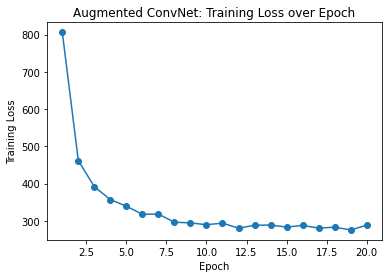

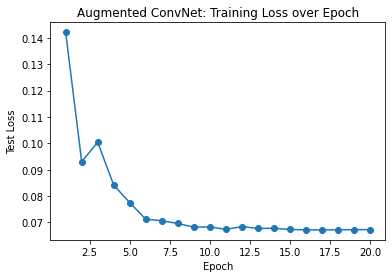

In [516]:
test(aug_basic_model, train_loader, subset_indices_valid) 
test(aug_basic_model, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = augmented_basic_training_losses_over_epochs
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Augmented ConvNet: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = augmented_basic_test_losses_over_epochs
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Augmented ConvNet: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

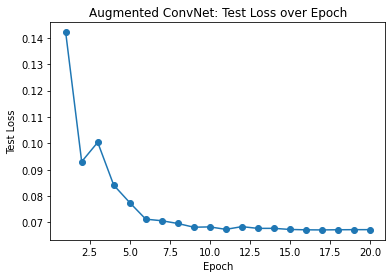

In [517]:

x = list(range(1, epochs + 1))
y = augmented_basic_test_losses_over_epochs
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Augmented ConvNet: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

## Train my own network

In [574]:


class MyConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, padding=2, padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), stride=1, padding=2, padding_mode = 'reflect')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=2, padding_mode = 'reflect')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=2, padding_mode = 'reflect')
        
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(128, 96)
        self.bn1 = nn.BatchNorm1d(num_features=96)
        self.fc2 = nn.Linear(96, 10)

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = F.relu(x)
#         print(x.shape)
        x = F.max_pool2d(x, 2)
#         print(x.shape)
        x = self.dropout1(x)
#         print(x.shape)
#         print(x.shape)

        x = self.conv2(x)
#         print(x.shape)
        x = F.relu(x)
#         print(x.shape)
        x = F.max_pool2d(x, 4)
#         print(x.shape)
        x = self.dropout2(x)
#         print(x.shape)
#         print(x.shape)
#         print(x)

        x = self.conv3(x)
#         print(x.shape)
        x = F.relu(x)
#         print(x.shape)
        x = F.avg_pool2d(x, 2)
#         print(x.shape)
        x = self.dropout2(x)
#         print(x.shape)
#         print(x.shape)
        
        x = self.conv4(x)
#         print(x.shape)
        x = F.relu(x)
#         print(x.shape)
        x = F.max_pool2d(x, 2)
#         print(x.shape)
        x = self.dropout2(x)
#         print(x.shape)
#         print(x.shape)

        x = torch.flatten(x, 1)
#         print(x.shape)
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x = self.bn1(x)
#         print(x.shape)
        
        x = F.relu(x)
#         print(x.shape)
        x = self.fc2(x)
#         print(x.shape)

        output = F.log_softmax(x, dim=1)
        return output

In [522]:
# Load your model [fcNet, ConvNet, Net]
my_basic_model2 = MyConvNet()
epochs = 15

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(my_basic_model2.parameters(), lr=0.01)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)
my_basic_model_training_errors = []
my_basic_model_test_errors = []
# Training loop
for epoch in range(1, epochs + 1):
    loss_ep = train(my_basic_model2, train_loader, optimizer, epoch, log_interval)
    
    test_loss, _, _ = test(my_basic_model2, val_loader, subset_indices_valid) 
    
    my_basic_model_training_errors.append(loss_ep)
    my_basic_model_test_errors.append(test_loss)
    
    scheduler.step()    # learning rate scheduler
    break
    # You may optionally save your model at each epoch here

# if save_model:
#     torch.save(my_basic_model.state_dict(), "mnist_model3.pt")

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.421830
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([3

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [2560/60000 (5%)]	Loss: 2.128606
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [5120/60000 (10%)]	Loss: 1.807391
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [9600/60000 (19%)]	Loss: 1.267988
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

Train Epoch: 1 [12800/60000 (25%)]	Loss: 1.184726
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 

torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [17600/60000 (35%)]	Loss: 0.905372
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32

torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.S

torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [21760/60000 (43%)]	Loss: 0.861398
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [24960/60000 (49%)]	Loss: 0.423909
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [26560/60000 (52%)]	Loss: 0.905723
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2,

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [31680/60000 (62%)]	Loss: 0.459668
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

Train Epoch: 1 [32640/60000 (64%)]	Loss: 0.440927
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
t

torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [38080/60000 (75%)]	Loss: 0.294489
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([3

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [39040/60000 (77%)]	Loss: 0.345664
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [40000/60000 (78%)]	Loss: 0.901674
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [40960/60000 (80%)]	Loss: 0.654849
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [41920/60000 (82%)]	Loss: 0.579927
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [42880/60000 (84%)]	Loss: 0.797166
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [43840/60000 (86%)]	Loss: 0.165457
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [44800/60000 (88%)]	Loss: 0.350666
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
t

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [45760/60000 (90%)]	Loss: 0.477225
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Si

torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
t

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
Train Epoch: 1 [50880/60000 (100%)]	Loss: 0.470963
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.S

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.S

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.S

torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size

torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.

torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.S

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2,

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
t

torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Siz

torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.

torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 2, 2])
torch.Size([32, 32, 2, 2])
torch.Size([32, 128])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 10])
torch.Size([32, 1, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 14, 14])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 5, 5])
torch.Size([32, 64, 2, 2])
torch.Size([32, 64, 2, 2])
torch.Size([32, 32, 4, 4])
torch.Size([32, 32, 4, 4])
torc

In [498]:

def ce_train(model,train_loader, optimizer, epoch, log_interval):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = nn.CrossEntropyLoss()
        
        output_loss = loss(output, target)   # Compute loss
        total_loss += output_loss.item()
        
        output_loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), output_loss))
    return total_loss


def ce_test(model, test_loader, subset_indices_valid):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_loss_ce = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            ce_loss = nn.CrossEntropyLoss()
            output_loss = ce_loss(output, target) 
            test_loss_ce += output_loss

    test_loss /= len(test_loader.dataset)
    
    total = len(subset_indices_valid)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    test_loss_nll = test_loss
    
    return test_loss_nll, test_loss_ce, correct, total



In [499]:
# Load your model [fcNet, ConvNet, Net]
my_better_model = MyConvNet()
epoch = 40

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(my_better_model.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

my_better_model_training_errors = []
my_better_model_nll_test_errors = []
my_better_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(my_better_model, train_loader, optimizer, epoch, log_interval)
    test_loss_nll, test_loss_ce, _, _ = ce_test(my_better_model, val_loader, subset_indices_valid) 
    
    my_better_model_training_errors.append(train_loss)
    my_better_model_nll_test_errors.append(test_loss_nll)
    my_better_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(my_better_model.state_dict(), "mnist_model4_2.pt")
    
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409681
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.334645
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.271186
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.195862
Train Epoch: 1 [1280/60000 (3%)]	Loss: 2.127477
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.060424
Train Epoch: 1 [1920/60000 (4%)]	Loss: 2.019894
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.123503
Train Epoch: 1 [2560/60000 (5%)]	Loss: 2.022640
Train Epoch: 1 [2880/60000 (6%)]	Loss: 2.112200
Train Epoch: 1 [3200/60000 (6%)]	Loss: 1.848670
Train Epoch: 1 [3520/60000 (7%)]	Loss: 1.936860
Train Epoch: 1 [3840/60000 (8%)]	Loss: 1.948544
Train Epoch: 1 [4160/60000 (8%)]	Loss: 1.954421
Train Epoch: 1 [4480/60000 (9%)]	Loss: 1.747081
Train Epoch: 1 [4800/60000 (9%)]	Loss: 1.809649
Train Epoch: 1 [5120/60000 (10%)]	Loss: 1.781864
Train Epoch: 1 [5440/60000 (11%)]	Loss: 1.442379
Train Epoch: 1 [5760/60000 (11%)]	Loss: 1.597387
Train Epoch: 1 [6080/60000 (12%)]	Loss: 1.654005
Train Epoch: 1 [6400/60000 (13%)]	Loss: 1.

Train Epoch: 2 [1280/60000 (3%)]	Loss: 0.163473
Train Epoch: 2 [1600/60000 (3%)]	Loss: 0.163184
Train Epoch: 2 [1920/60000 (4%)]	Loss: 0.389000
Train Epoch: 2 [2240/60000 (4%)]	Loss: 0.479908
Train Epoch: 2 [2560/60000 (5%)]	Loss: 0.466666
Train Epoch: 2 [2880/60000 (6%)]	Loss: 0.153277
Train Epoch: 2 [3200/60000 (6%)]	Loss: 0.403886
Train Epoch: 2 [3520/60000 (7%)]	Loss: 0.247897
Train Epoch: 2 [3840/60000 (8%)]	Loss: 0.773664
Train Epoch: 2 [4160/60000 (8%)]	Loss: 0.396121
Train Epoch: 2 [4480/60000 (9%)]	Loss: 0.392266
Train Epoch: 2 [4800/60000 (9%)]	Loss: 0.558720
Train Epoch: 2 [5120/60000 (10%)]	Loss: 0.687876
Train Epoch: 2 [5440/60000 (11%)]	Loss: 0.271557
Train Epoch: 2 [5760/60000 (11%)]	Loss: 0.284455
Train Epoch: 2 [6080/60000 (12%)]	Loss: 0.368438
Train Epoch: 2 [6400/60000 (13%)]	Loss: 0.684204
Train Epoch: 2 [6720/60000 (13%)]	Loss: 0.482245
Train Epoch: 2 [7040/60000 (14%)]	Loss: 0.517273
Train Epoch: 2 [7360/60000 (14%)]	Loss: 0.478173
Train Epoch: 2 [7680/60000 (15%)

Train Epoch: 3 [2560/60000 (5%)]	Loss: 0.095753
Train Epoch: 3 [2880/60000 (6%)]	Loss: 0.353499
Train Epoch: 3 [3200/60000 (6%)]	Loss: 0.148494
Train Epoch: 3 [3520/60000 (7%)]	Loss: 0.254310
Train Epoch: 3 [3840/60000 (8%)]	Loss: 0.141501
Train Epoch: 3 [4160/60000 (8%)]	Loss: 0.209677
Train Epoch: 3 [4480/60000 (9%)]	Loss: 0.249617
Train Epoch: 3 [4800/60000 (9%)]	Loss: 0.176146
Train Epoch: 3 [5120/60000 (10%)]	Loss: 0.106313
Train Epoch: 3 [5440/60000 (11%)]	Loss: 0.654886
Train Epoch: 3 [5760/60000 (11%)]	Loss: 0.257501
Train Epoch: 3 [6080/60000 (12%)]	Loss: 0.272835
Train Epoch: 3 [6400/60000 (13%)]	Loss: 0.328394
Train Epoch: 3 [6720/60000 (13%)]	Loss: 0.435638
Train Epoch: 3 [7040/60000 (14%)]	Loss: 0.200496
Train Epoch: 3 [7360/60000 (14%)]	Loss: 0.224928
Train Epoch: 3 [7680/60000 (15%)]	Loss: 0.099233
Train Epoch: 3 [8000/60000 (16%)]	Loss: 0.176222
Train Epoch: 3 [8320/60000 (16%)]	Loss: 0.317247
Train Epoch: 3 [8640/60000 (17%)]	Loss: 0.230043
Train Epoch: 3 [8960/60000 (

Train Epoch: 4 [3840/60000 (8%)]	Loss: 0.217859
Train Epoch: 4 [4160/60000 (8%)]	Loss: 0.140637
Train Epoch: 4 [4480/60000 (9%)]	Loss: 0.060679
Train Epoch: 4 [4800/60000 (9%)]	Loss: 0.443753
Train Epoch: 4 [5120/60000 (10%)]	Loss: 0.241663
Train Epoch: 4 [5440/60000 (11%)]	Loss: 0.346681
Train Epoch: 4 [5760/60000 (11%)]	Loss: 0.080520
Train Epoch: 4 [6080/60000 (12%)]	Loss: 0.112241
Train Epoch: 4 [6400/60000 (13%)]	Loss: 0.287507
Train Epoch: 4 [6720/60000 (13%)]	Loss: 0.444218
Train Epoch: 4 [7040/60000 (14%)]	Loss: 0.385151
Train Epoch: 4 [7360/60000 (14%)]	Loss: 0.094675
Train Epoch: 4 [7680/60000 (15%)]	Loss: 0.411193
Train Epoch: 4 [8000/60000 (16%)]	Loss: 0.141491
Train Epoch: 4 [8320/60000 (16%)]	Loss: 0.227254
Train Epoch: 4 [8640/60000 (17%)]	Loss: 0.075891
Train Epoch: 4 [8960/60000 (18%)]	Loss: 0.077828
Train Epoch: 4 [9280/60000 (18%)]	Loss: 0.358508
Train Epoch: 4 [9600/60000 (19%)]	Loss: 0.121946
Train Epoch: 4 [9920/60000 (19%)]	Loss: 0.328032
Train Epoch: 4 [10240/60

Train Epoch: 5 [5120/60000 (10%)]	Loss: 0.250168
Train Epoch: 5 [5440/60000 (11%)]	Loss: 0.240847
Train Epoch: 5 [5760/60000 (11%)]	Loss: 0.304464
Train Epoch: 5 [6080/60000 (12%)]	Loss: 0.483344
Train Epoch: 5 [6400/60000 (13%)]	Loss: 0.064523
Train Epoch: 5 [6720/60000 (13%)]	Loss: 0.125299
Train Epoch: 5 [7040/60000 (14%)]	Loss: 0.182811
Train Epoch: 5 [7360/60000 (14%)]	Loss: 0.244660
Train Epoch: 5 [7680/60000 (15%)]	Loss: 0.539701
Train Epoch: 5 [8000/60000 (16%)]	Loss: 0.245482
Train Epoch: 5 [8320/60000 (16%)]	Loss: 0.337056
Train Epoch: 5 [8640/60000 (17%)]	Loss: 0.080891
Train Epoch: 5 [8960/60000 (18%)]	Loss: 0.420867
Train Epoch: 5 [9280/60000 (18%)]	Loss: 0.126777
Train Epoch: 5 [9600/60000 (19%)]	Loss: 0.105558
Train Epoch: 5 [9920/60000 (19%)]	Loss: 0.123361
Train Epoch: 5 [10240/60000 (20%)]	Loss: 0.514934
Train Epoch: 5 [10560/60000 (21%)]	Loss: 0.027656
Train Epoch: 5 [10880/60000 (21%)]	Loss: 0.208184
Train Epoch: 5 [11200/60000 (22%)]	Loss: 0.199988
Train Epoch: 5 [

Train Epoch: 6 [6400/60000 (13%)]	Loss: 0.042081
Train Epoch: 6 [6720/60000 (13%)]	Loss: 0.126518
Train Epoch: 6 [7040/60000 (14%)]	Loss: 0.254737
Train Epoch: 6 [7360/60000 (14%)]	Loss: 0.400107
Train Epoch: 6 [7680/60000 (15%)]	Loss: 0.104317
Train Epoch: 6 [8000/60000 (16%)]	Loss: 0.088528
Train Epoch: 6 [8320/60000 (16%)]	Loss: 0.049373
Train Epoch: 6 [8640/60000 (17%)]	Loss: 0.146730
Train Epoch: 6 [8960/60000 (18%)]	Loss: 0.147941
Train Epoch: 6 [9280/60000 (18%)]	Loss: 0.069047
Train Epoch: 6 [9600/60000 (19%)]	Loss: 0.247397
Train Epoch: 6 [9920/60000 (19%)]	Loss: 0.041000
Train Epoch: 6 [10240/60000 (20%)]	Loss: 0.188052
Train Epoch: 6 [10560/60000 (21%)]	Loss: 0.183395
Train Epoch: 6 [10880/60000 (21%)]	Loss: 0.022473
Train Epoch: 6 [11200/60000 (22%)]	Loss: 0.203038
Train Epoch: 6 [11520/60000 (23%)]	Loss: 0.305962
Train Epoch: 6 [11840/60000 (23%)]	Loss: 0.482020
Train Epoch: 6 [12160/60000 (24%)]	Loss: 0.061692
Train Epoch: 6 [12480/60000 (24%)]	Loss: 0.060723
Train Epoch:

Train Epoch: 7 [7680/60000 (15%)]	Loss: 0.132485
Train Epoch: 7 [8000/60000 (16%)]	Loss: 0.057007
Train Epoch: 7 [8320/60000 (16%)]	Loss: 0.389288
Train Epoch: 7 [8640/60000 (17%)]	Loss: 0.146562
Train Epoch: 7 [8960/60000 (18%)]	Loss: 0.123098
Train Epoch: 7 [9280/60000 (18%)]	Loss: 0.145485
Train Epoch: 7 [9600/60000 (19%)]	Loss: 0.250875
Train Epoch: 7 [9920/60000 (19%)]	Loss: 0.293901
Train Epoch: 7 [10240/60000 (20%)]	Loss: 0.213975
Train Epoch: 7 [10560/60000 (21%)]	Loss: 0.236407
Train Epoch: 7 [10880/60000 (21%)]	Loss: 0.192345
Train Epoch: 7 [11200/60000 (22%)]	Loss: 0.312309
Train Epoch: 7 [11520/60000 (23%)]	Loss: 0.130142
Train Epoch: 7 [11840/60000 (23%)]	Loss: 0.072304
Train Epoch: 7 [12160/60000 (24%)]	Loss: 0.198820
Train Epoch: 7 [12480/60000 (24%)]	Loss: 0.258265
Train Epoch: 7 [12800/60000 (25%)]	Loss: 0.137909
Train Epoch: 7 [13120/60000 (26%)]	Loss: 0.109030
Train Epoch: 7 [13440/60000 (26%)]	Loss: 0.172815
Train Epoch: 7 [13760/60000 (27%)]	Loss: 0.080728
Train Ep

Train Epoch: 8 [8960/60000 (18%)]	Loss: 0.068395
Train Epoch: 8 [9280/60000 (18%)]	Loss: 0.181116
Train Epoch: 8 [9600/60000 (19%)]	Loss: 0.025830
Train Epoch: 8 [9920/60000 (19%)]	Loss: 0.183701
Train Epoch: 8 [10240/60000 (20%)]	Loss: 0.181853
Train Epoch: 8 [10560/60000 (21%)]	Loss: 0.358142
Train Epoch: 8 [10880/60000 (21%)]	Loss: 0.167290
Train Epoch: 8 [11200/60000 (22%)]	Loss: 0.092647
Train Epoch: 8 [11520/60000 (23%)]	Loss: 0.220370
Train Epoch: 8 [11840/60000 (23%)]	Loss: 0.206376
Train Epoch: 8 [12160/60000 (24%)]	Loss: 0.035419
Train Epoch: 8 [12480/60000 (24%)]	Loss: 0.145371
Train Epoch: 8 [12800/60000 (25%)]	Loss: 0.123223
Train Epoch: 8 [13120/60000 (26%)]	Loss: 0.285762
Train Epoch: 8 [13440/60000 (26%)]	Loss: 0.401555
Train Epoch: 8 [13760/60000 (27%)]	Loss: 0.465585
Train Epoch: 8 [14080/60000 (28%)]	Loss: 0.128755
Train Epoch: 8 [14400/60000 (28%)]	Loss: 0.132372
Train Epoch: 8 [14720/60000 (29%)]	Loss: 0.134298
Train Epoch: 8 [15040/60000 (29%)]	Loss: 0.197412
Trai

Train Epoch: 9 [10240/60000 (20%)]	Loss: 0.132395
Train Epoch: 9 [10560/60000 (21%)]	Loss: 0.217625
Train Epoch: 9 [10880/60000 (21%)]	Loss: 0.004920
Train Epoch: 9 [11200/60000 (22%)]	Loss: 0.104527
Train Epoch: 9 [11520/60000 (23%)]	Loss: 0.046135
Train Epoch: 9 [11840/60000 (23%)]	Loss: 0.107256
Train Epoch: 9 [12160/60000 (24%)]	Loss: 0.060831
Train Epoch: 9 [12480/60000 (24%)]	Loss: 0.155362
Train Epoch: 9 [12800/60000 (25%)]	Loss: 0.059863
Train Epoch: 9 [13120/60000 (26%)]	Loss: 0.054266
Train Epoch: 9 [13440/60000 (26%)]	Loss: 0.274986
Train Epoch: 9 [13760/60000 (27%)]	Loss: 0.109774
Train Epoch: 9 [14080/60000 (28%)]	Loss: 0.114888
Train Epoch: 9 [14400/60000 (28%)]	Loss: 0.253849
Train Epoch: 9 [14720/60000 (29%)]	Loss: 0.224907
Train Epoch: 9 [15040/60000 (29%)]	Loss: 0.068437
Train Epoch: 9 [15360/60000 (30%)]	Loss: 0.184251
Train Epoch: 9 [15680/60000 (31%)]	Loss: 0.155768
Train Epoch: 9 [16000/60000 (31%)]	Loss: 0.072498
Train Epoch: 9 [16320/60000 (32%)]	Loss: 0.096563


Train Epoch: 10 [11200/60000 (22%)]	Loss: 0.010752
Train Epoch: 10 [11520/60000 (23%)]	Loss: 0.021265
Train Epoch: 10 [11840/60000 (23%)]	Loss: 0.279317
Train Epoch: 10 [12160/60000 (24%)]	Loss: 0.067161
Train Epoch: 10 [12480/60000 (24%)]	Loss: 0.173650
Train Epoch: 10 [12800/60000 (25%)]	Loss: 0.210934
Train Epoch: 10 [13120/60000 (26%)]	Loss: 0.305550
Train Epoch: 10 [13440/60000 (26%)]	Loss: 0.142892
Train Epoch: 10 [13760/60000 (27%)]	Loss: 0.053684
Train Epoch: 10 [14080/60000 (28%)]	Loss: 0.257162
Train Epoch: 10 [14400/60000 (28%)]	Loss: 0.076009
Train Epoch: 10 [14720/60000 (29%)]	Loss: 0.043777
Train Epoch: 10 [15040/60000 (29%)]	Loss: 0.142951
Train Epoch: 10 [15360/60000 (30%)]	Loss: 0.192415
Train Epoch: 10 [15680/60000 (31%)]	Loss: 0.006203
Train Epoch: 10 [16000/60000 (31%)]	Loss: 0.042832
Train Epoch: 10 [16320/60000 (32%)]	Loss: 0.271275
Train Epoch: 10 [16640/60000 (33%)]	Loss: 0.535850
Train Epoch: 10 [16960/60000 (33%)]	Loss: 0.090226
Train Epoch: 10 [17280/60000 (3

Train Epoch: 11 [11520/60000 (23%)]	Loss: 0.078501
Train Epoch: 11 [11840/60000 (23%)]	Loss: 0.065421
Train Epoch: 11 [12160/60000 (24%)]	Loss: 0.328771
Train Epoch: 11 [12480/60000 (24%)]	Loss: 0.096285
Train Epoch: 11 [12800/60000 (25%)]	Loss: 0.119014
Train Epoch: 11 [13120/60000 (26%)]	Loss: 0.064807
Train Epoch: 11 [13440/60000 (26%)]	Loss: 0.331388
Train Epoch: 11 [13760/60000 (27%)]	Loss: 0.606290
Train Epoch: 11 [14080/60000 (28%)]	Loss: 0.073233
Train Epoch: 11 [14400/60000 (28%)]	Loss: 0.096740
Train Epoch: 11 [14720/60000 (29%)]	Loss: 0.056602
Train Epoch: 11 [15040/60000 (29%)]	Loss: 0.039817
Train Epoch: 11 [15360/60000 (30%)]	Loss: 0.209906
Train Epoch: 11 [15680/60000 (31%)]	Loss: 0.169933
Train Epoch: 11 [16000/60000 (31%)]	Loss: 0.026981
Train Epoch: 11 [16320/60000 (32%)]	Loss: 0.140789
Train Epoch: 11 [16640/60000 (33%)]	Loss: 0.199291
Train Epoch: 11 [16960/60000 (33%)]	Loss: 0.093271
Train Epoch: 11 [17280/60000 (34%)]	Loss: 0.228957
Train Epoch: 11 [17600/60000 (3

Train Epoch: 12 [11840/60000 (23%)]	Loss: 0.109048
Train Epoch: 12 [12160/60000 (24%)]	Loss: 0.158013
Train Epoch: 12 [12480/60000 (24%)]	Loss: 0.107808
Train Epoch: 12 [12800/60000 (25%)]	Loss: 0.207172
Train Epoch: 12 [13120/60000 (26%)]	Loss: 0.073406
Train Epoch: 12 [13440/60000 (26%)]	Loss: 0.088988
Train Epoch: 12 [13760/60000 (27%)]	Loss: 0.122050
Train Epoch: 12 [14080/60000 (28%)]	Loss: 0.159743
Train Epoch: 12 [14400/60000 (28%)]	Loss: 0.023796
Train Epoch: 12 [14720/60000 (29%)]	Loss: 0.280878
Train Epoch: 12 [15040/60000 (29%)]	Loss: 0.035620
Train Epoch: 12 [15360/60000 (30%)]	Loss: 0.163496
Train Epoch: 12 [15680/60000 (31%)]	Loss: 0.135762
Train Epoch: 12 [16000/60000 (31%)]	Loss: 0.195432
Train Epoch: 12 [16320/60000 (32%)]	Loss: 0.215224
Train Epoch: 12 [16640/60000 (33%)]	Loss: 0.093734
Train Epoch: 12 [16960/60000 (33%)]	Loss: 0.028573
Train Epoch: 12 [17280/60000 (34%)]	Loss: 0.041948
Train Epoch: 12 [17600/60000 (35%)]	Loss: 0.278251
Train Epoch: 12 [17920/60000 (3

Train Epoch: 13 [12160/60000 (24%)]	Loss: 0.333010
Train Epoch: 13 [12480/60000 (24%)]	Loss: 0.105429
Train Epoch: 13 [12800/60000 (25%)]	Loss: 0.394005
Train Epoch: 13 [13120/60000 (26%)]	Loss: 0.257173
Train Epoch: 13 [13440/60000 (26%)]	Loss: 0.283194
Train Epoch: 13 [13760/60000 (27%)]	Loss: 0.036042
Train Epoch: 13 [14080/60000 (28%)]	Loss: 0.067279
Train Epoch: 13 [14400/60000 (28%)]	Loss: 0.102623
Train Epoch: 13 [14720/60000 (29%)]	Loss: 0.276664
Train Epoch: 13 [15040/60000 (29%)]	Loss: 0.111827
Train Epoch: 13 [15360/60000 (30%)]	Loss: 0.042225
Train Epoch: 13 [15680/60000 (31%)]	Loss: 0.242005
Train Epoch: 13 [16000/60000 (31%)]	Loss: 0.058341
Train Epoch: 13 [16320/60000 (32%)]	Loss: 0.186735
Train Epoch: 13 [16640/60000 (33%)]	Loss: 0.160508
Train Epoch: 13 [16960/60000 (33%)]	Loss: 0.167357
Train Epoch: 13 [17280/60000 (34%)]	Loss: 0.417109
Train Epoch: 13 [17600/60000 (35%)]	Loss: 0.040871
Train Epoch: 13 [17920/60000 (35%)]	Loss: 0.183167
Train Epoch: 13 [18240/60000 (3

Train Epoch: 14 [12480/60000 (24%)]	Loss: 0.094795
Train Epoch: 14 [12800/60000 (25%)]	Loss: 0.028095
Train Epoch: 14 [13120/60000 (26%)]	Loss: 0.065075
Train Epoch: 14 [13440/60000 (26%)]	Loss: 0.254952
Train Epoch: 14 [13760/60000 (27%)]	Loss: 0.061978
Train Epoch: 14 [14080/60000 (28%)]	Loss: 0.195972
Train Epoch: 14 [14400/60000 (28%)]	Loss: 0.158605
Train Epoch: 14 [14720/60000 (29%)]	Loss: 0.361821
Train Epoch: 14 [15040/60000 (29%)]	Loss: 0.080277
Train Epoch: 14 [15360/60000 (30%)]	Loss: 0.040231
Train Epoch: 14 [15680/60000 (31%)]	Loss: 0.054502
Train Epoch: 14 [16000/60000 (31%)]	Loss: 0.167291
Train Epoch: 14 [16320/60000 (32%)]	Loss: 0.177068
Train Epoch: 14 [16640/60000 (33%)]	Loss: 0.055756
Train Epoch: 14 [16960/60000 (33%)]	Loss: 0.487297
Train Epoch: 14 [17280/60000 (34%)]	Loss: 0.284236
Train Epoch: 14 [17600/60000 (35%)]	Loss: 0.281741
Train Epoch: 14 [17920/60000 (35%)]	Loss: 0.070225
Train Epoch: 14 [18240/60000 (36%)]	Loss: 0.131867
Train Epoch: 14 [18560/60000 (3

Train Epoch: 15 [12800/60000 (25%)]	Loss: 0.075349
Train Epoch: 15 [13120/60000 (26%)]	Loss: 0.228765
Train Epoch: 15 [13440/60000 (26%)]	Loss: 0.137237
Train Epoch: 15 [13760/60000 (27%)]	Loss: 0.049568
Train Epoch: 15 [14080/60000 (28%)]	Loss: 0.162894
Train Epoch: 15 [14400/60000 (28%)]	Loss: 0.186157
Train Epoch: 15 [14720/60000 (29%)]	Loss: 0.108487
Train Epoch: 15 [15040/60000 (29%)]	Loss: 0.040592
Train Epoch: 15 [15360/60000 (30%)]	Loss: 0.457387
Train Epoch: 15 [15680/60000 (31%)]	Loss: 0.005145
Train Epoch: 15 [16000/60000 (31%)]	Loss: 0.324035
Train Epoch: 15 [16320/60000 (32%)]	Loss: 0.027837
Train Epoch: 15 [16640/60000 (33%)]	Loss: 0.144213
Train Epoch: 15 [16960/60000 (33%)]	Loss: 0.072677
Train Epoch: 15 [17280/60000 (34%)]	Loss: 0.071770
Train Epoch: 15 [17600/60000 (35%)]	Loss: 0.382695
Train Epoch: 15 [17920/60000 (35%)]	Loss: 0.206992
Train Epoch: 15 [18240/60000 (36%)]	Loss: 0.039476
Train Epoch: 15 [18560/60000 (36%)]	Loss: 0.166907
Train Epoch: 15 [18880/60000 (3

Train Epoch: 16 [13120/60000 (26%)]	Loss: 0.140130
Train Epoch: 16 [13440/60000 (26%)]	Loss: 0.053454
Train Epoch: 16 [13760/60000 (27%)]	Loss: 0.059032
Train Epoch: 16 [14080/60000 (28%)]	Loss: 0.162835
Train Epoch: 16 [14400/60000 (28%)]	Loss: 0.398437
Train Epoch: 16 [14720/60000 (29%)]	Loss: 0.133050
Train Epoch: 16 [15040/60000 (29%)]	Loss: 0.138018
Train Epoch: 16 [15360/60000 (30%)]	Loss: 0.203694
Train Epoch: 16 [15680/60000 (31%)]	Loss: 0.292402
Train Epoch: 16 [16000/60000 (31%)]	Loss: 0.197897
Train Epoch: 16 [16320/60000 (32%)]	Loss: 0.364016
Train Epoch: 16 [16640/60000 (33%)]	Loss: 0.189670
Train Epoch: 16 [16960/60000 (33%)]	Loss: 0.096723
Train Epoch: 16 [17280/60000 (34%)]	Loss: 0.127606
Train Epoch: 16 [17600/60000 (35%)]	Loss: 0.445799
Train Epoch: 16 [17920/60000 (35%)]	Loss: 0.261512
Train Epoch: 16 [18240/60000 (36%)]	Loss: 0.087115
Train Epoch: 16 [18560/60000 (36%)]	Loss: 0.125060
Train Epoch: 16 [18880/60000 (37%)]	Loss: 0.544955
Train Epoch: 16 [19200/60000 (3

Train Epoch: 17 [13440/60000 (26%)]	Loss: 0.069627
Train Epoch: 17 [13760/60000 (27%)]	Loss: 0.070234
Train Epoch: 17 [14080/60000 (28%)]	Loss: 0.184353
Train Epoch: 17 [14400/60000 (28%)]	Loss: 0.140495
Train Epoch: 17 [14720/60000 (29%)]	Loss: 0.134505
Train Epoch: 17 [15040/60000 (29%)]	Loss: 0.053834
Train Epoch: 17 [15360/60000 (30%)]	Loss: 0.161026
Train Epoch: 17 [15680/60000 (31%)]	Loss: 0.273791
Train Epoch: 17 [16000/60000 (31%)]	Loss: 0.105760
Train Epoch: 17 [16320/60000 (32%)]	Loss: 0.246506
Train Epoch: 17 [16640/60000 (33%)]	Loss: 0.020858
Train Epoch: 17 [16960/60000 (33%)]	Loss: 0.097765
Train Epoch: 17 [17280/60000 (34%)]	Loss: 0.010445
Train Epoch: 17 [17600/60000 (35%)]	Loss: 0.210916
Train Epoch: 17 [17920/60000 (35%)]	Loss: 0.043293
Train Epoch: 17 [18240/60000 (36%)]	Loss: 0.081438
Train Epoch: 17 [18560/60000 (36%)]	Loss: 0.025713
Train Epoch: 17 [18880/60000 (37%)]	Loss: 0.211629
Train Epoch: 17 [19200/60000 (38%)]	Loss: 0.166598
Train Epoch: 17 [19520/60000 (3

Train Epoch: 18 [13760/60000 (27%)]	Loss: 0.107155
Train Epoch: 18 [14080/60000 (28%)]	Loss: 0.285398
Train Epoch: 18 [14400/60000 (28%)]	Loss: 0.186118
Train Epoch: 18 [14720/60000 (29%)]	Loss: 0.104365
Train Epoch: 18 [15040/60000 (29%)]	Loss: 0.152973
Train Epoch: 18 [15360/60000 (30%)]	Loss: 0.032927
Train Epoch: 18 [15680/60000 (31%)]	Loss: 0.031071
Train Epoch: 18 [16000/60000 (31%)]	Loss: 0.260534
Train Epoch: 18 [16320/60000 (32%)]	Loss: 0.064668
Train Epoch: 18 [16640/60000 (33%)]	Loss: 0.258421
Train Epoch: 18 [16960/60000 (33%)]	Loss: 0.066873
Train Epoch: 18 [17280/60000 (34%)]	Loss: 0.054943
Train Epoch: 18 [17600/60000 (35%)]	Loss: 0.062044
Train Epoch: 18 [17920/60000 (35%)]	Loss: 0.062584
Train Epoch: 18 [18240/60000 (36%)]	Loss: 0.022359
Train Epoch: 18 [18560/60000 (36%)]	Loss: 0.132815
Train Epoch: 18 [18880/60000 (37%)]	Loss: 0.114156
Train Epoch: 18 [19200/60000 (38%)]	Loss: 0.229281
Train Epoch: 18 [19520/60000 (38%)]	Loss: 0.288746
Train Epoch: 18 [19840/60000 (3

Train Epoch: 19 [14080/60000 (28%)]	Loss: 0.224422
Train Epoch: 19 [14400/60000 (28%)]	Loss: 0.173358
Train Epoch: 19 [14720/60000 (29%)]	Loss: 0.057559
Train Epoch: 19 [15040/60000 (29%)]	Loss: 0.110245
Train Epoch: 19 [15360/60000 (30%)]	Loss: 0.270165
Train Epoch: 19 [15680/60000 (31%)]	Loss: 0.098660
Train Epoch: 19 [16000/60000 (31%)]	Loss: 0.382287
Train Epoch: 19 [16320/60000 (32%)]	Loss: 0.017302
Train Epoch: 19 [16640/60000 (33%)]	Loss: 0.064410
Train Epoch: 19 [16960/60000 (33%)]	Loss: 0.258179
Train Epoch: 19 [17280/60000 (34%)]	Loss: 0.099305
Train Epoch: 19 [17600/60000 (35%)]	Loss: 0.034323
Train Epoch: 19 [17920/60000 (35%)]	Loss: 0.129442
Train Epoch: 19 [18240/60000 (36%)]	Loss: 0.183969
Train Epoch: 19 [18560/60000 (36%)]	Loss: 0.246977
Train Epoch: 19 [18880/60000 (37%)]	Loss: 0.082939
Train Epoch: 19 [19200/60000 (38%)]	Loss: 0.055826
Train Epoch: 19 [19520/60000 (38%)]	Loss: 0.211321
Train Epoch: 19 [19840/60000 (39%)]	Loss: 0.295661
Train Epoch: 19 [20160/60000 (4

Train Epoch: 20 [14400/60000 (28%)]	Loss: 0.148466
Train Epoch: 20 [14720/60000 (29%)]	Loss: 0.178258
Train Epoch: 20 [15040/60000 (29%)]	Loss: 0.277543
Train Epoch: 20 [15360/60000 (30%)]	Loss: 0.336894
Train Epoch: 20 [15680/60000 (31%)]	Loss: 0.265954
Train Epoch: 20 [16000/60000 (31%)]	Loss: 0.103335
Train Epoch: 20 [16320/60000 (32%)]	Loss: 0.143900
Train Epoch: 20 [16640/60000 (33%)]	Loss: 0.067164
Train Epoch: 20 [16960/60000 (33%)]	Loss: 0.325545
Train Epoch: 20 [17280/60000 (34%)]	Loss: 0.131713
Train Epoch: 20 [17600/60000 (35%)]	Loss: 0.196364
Train Epoch: 20 [17920/60000 (35%)]	Loss: 0.031242
Train Epoch: 20 [18240/60000 (36%)]	Loss: 0.058226
Train Epoch: 20 [18560/60000 (36%)]	Loss: 0.168116
Train Epoch: 20 [18880/60000 (37%)]	Loss: 0.042282
Train Epoch: 20 [19200/60000 (38%)]	Loss: 0.090560
Train Epoch: 20 [19520/60000 (38%)]	Loss: 0.264520
Train Epoch: 20 [19840/60000 (39%)]	Loss: 0.106390
Train Epoch: 20 [20160/60000 (40%)]	Loss: 0.162220
Train Epoch: 20 [20480/60000 (4

In [500]:
test(model, test_loader, range(len(test_loader)))


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (99%)



(0.03403181433582245, 9893, 10000)


Test set: Average loss: 0.0454, Accuracy: 50180/60000 (84%)


Test set: Average loss: 0.0570, Accuracy: 9826/10000 (98%)



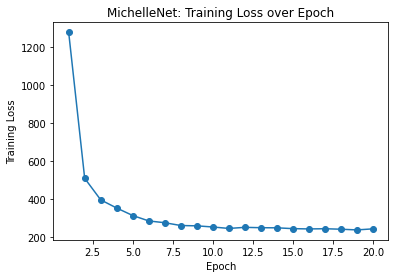

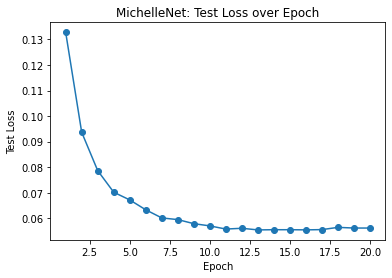

In [525]:
test(my_better_model, train_loader, subset_indices_valid) 
test(my_better_model, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = my_better_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("MichelleNet: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = my_better_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("MichelleNet: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

In [501]:
# torch.save(model.state_dict(), "mnist_model4.pt")

In [502]:
aug_train_dataset = datasets.MNIST('./data', train=True, download=False,
            transform=transforms.Compose([       # Data preprocessing
                
                torchvision.transforms.RandomAffine(degrees=15, translate=None, 
                                                    scale=None, shear=None, 
                                                    resample=False, fillcolor=0),
                transforms.ToTensor(),           # Add data augmentation here
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

aug_all_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=batch_size
)

aug_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_train)
)
aug_val_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid)
)


In [503]:
# Load your model [fcNet, ConvNet, Net]
my_aug_better_model = MyConvNet()
epoch = 40

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(my_aug_better_model.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

my_aug_better_model_training_errors = []
my_aug_better_model_nll_test_errors = []
my_aug_better_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(my_aug_better_model, aug_train_loader, optimizer, epoch, log_interval)
    test_loss_nll, test_loss_ce, _, _ = ce_test(my_aug_better_model, aug_val_loader, subset_indices_valid) 
    
    my_aug_better_model_training_errors.append(train_loss)
    my_aug_better_model_nll_test_errors.append(test_loss_nll)
    my_aug_better_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(my_aug_better_model.state_dict(), "mnist_model4_aug_2.pt")
    
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.404810
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.320397
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287424
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.310651
Train Epoch: 1 [1280/60000 (3%)]	Loss: 2.146691
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.129191
Train Epoch: 1 [1920/60000 (4%)]	Loss: 2.140932
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.021312
Train Epoch: 1 [2560/60000 (5%)]	Loss: 2.107658
Train Epoch: 1 [2880/60000 (6%)]	Loss: 1.932686
Train Epoch: 1 [3200/60000 (6%)]	Loss: 2.064836
Train Epoch: 1 [3520/60000 (7%)]	Loss: 1.811664
Train Epoch: 1 [3840/60000 (8%)]	Loss: 1.872332
Train Epoch: 1 [4160/60000 (8%)]	Loss: 1.789695
Train Epoch: 1 [4480/60000 (9%)]	Loss: 1.673835
Train Epoch: 1 [4800/60000 (9%)]	Loss: 1.726052
Train Epoch: 1 [5120/60000 (10%)]	Loss: 1.624632
Train Epoch: 1 [5440/60000 (11%)]	Loss: 1.693848
Train Epoch: 1 [5760/60000 (11%)]	Loss: 1.741476
Train Epoch: 1 [6080/60000 (12%)]	Loss: 1.688630
Train Epoch: 1 [6400/60000 (13%)]	Loss: 1.

Train Epoch: 2 [1280/60000 (3%)]	Loss: 0.305054
Train Epoch: 2 [1600/60000 (3%)]	Loss: 0.436243
Train Epoch: 2 [1920/60000 (4%)]	Loss: 0.807420
Train Epoch: 2 [2240/60000 (4%)]	Loss: 0.504927
Train Epoch: 2 [2560/60000 (5%)]	Loss: 0.385157
Train Epoch: 2 [2880/60000 (6%)]	Loss: 0.699908
Train Epoch: 2 [3200/60000 (6%)]	Loss: 0.294841
Train Epoch: 2 [3520/60000 (7%)]	Loss: 0.573344
Train Epoch: 2 [3840/60000 (8%)]	Loss: 0.241583
Train Epoch: 2 [4160/60000 (8%)]	Loss: 0.465188
Train Epoch: 2 [4480/60000 (9%)]	Loss: 0.607075
Train Epoch: 2 [4800/60000 (9%)]	Loss: 0.371771
Train Epoch: 2 [5120/60000 (10%)]	Loss: 0.627450
Train Epoch: 2 [5440/60000 (11%)]	Loss: 0.382243
Train Epoch: 2 [5760/60000 (11%)]	Loss: 0.505410
Train Epoch: 2 [6080/60000 (12%)]	Loss: 0.730826
Train Epoch: 2 [6400/60000 (13%)]	Loss: 0.431937
Train Epoch: 2 [6720/60000 (13%)]	Loss: 0.251977
Train Epoch: 2 [7040/60000 (14%)]	Loss: 0.449678
Train Epoch: 2 [7360/60000 (14%)]	Loss: 0.381414
Train Epoch: 2 [7680/60000 (15%)

Train Epoch: 3 [2560/60000 (5%)]	Loss: 0.631283
Train Epoch: 3 [2880/60000 (6%)]	Loss: 0.405857
Train Epoch: 3 [3200/60000 (6%)]	Loss: 0.238049
Train Epoch: 3 [3520/60000 (7%)]	Loss: 0.120003
Train Epoch: 3 [3840/60000 (8%)]	Loss: 0.202449
Train Epoch: 3 [4160/60000 (8%)]	Loss: 0.485905
Train Epoch: 3 [4480/60000 (9%)]	Loss: 0.429073
Train Epoch: 3 [4800/60000 (9%)]	Loss: 0.185189
Train Epoch: 3 [5120/60000 (10%)]	Loss: 0.407555
Train Epoch: 3 [5440/60000 (11%)]	Loss: 0.214778
Train Epoch: 3 [5760/60000 (11%)]	Loss: 0.511790
Train Epoch: 3 [6080/60000 (12%)]	Loss: 0.252408
Train Epoch: 3 [6400/60000 (13%)]	Loss: 0.467780
Train Epoch: 3 [6720/60000 (13%)]	Loss: 0.248881
Train Epoch: 3 [7040/60000 (14%)]	Loss: 0.310167
Train Epoch: 3 [7360/60000 (14%)]	Loss: 0.216182
Train Epoch: 3 [7680/60000 (15%)]	Loss: 0.225075
Train Epoch: 3 [8000/60000 (16%)]	Loss: 0.085745
Train Epoch: 3 [8320/60000 (16%)]	Loss: 0.310912
Train Epoch: 3 [8640/60000 (17%)]	Loss: 0.491405
Train Epoch: 3 [8960/60000 (

Train Epoch: 4 [3840/60000 (8%)]	Loss: 0.440360
Train Epoch: 4 [4160/60000 (8%)]	Loss: 0.229853
Train Epoch: 4 [4480/60000 (9%)]	Loss: 0.239232
Train Epoch: 4 [4800/60000 (9%)]	Loss: 0.221934
Train Epoch: 4 [5120/60000 (10%)]	Loss: 0.237847
Train Epoch: 4 [5440/60000 (11%)]	Loss: 0.225232
Train Epoch: 4 [5760/60000 (11%)]	Loss: 0.334284
Train Epoch: 4 [6080/60000 (12%)]	Loss: 0.227186
Train Epoch: 4 [6400/60000 (13%)]	Loss: 0.163739
Train Epoch: 4 [6720/60000 (13%)]	Loss: 0.310320
Train Epoch: 4 [7040/60000 (14%)]	Loss: 0.124217
Train Epoch: 4 [7360/60000 (14%)]	Loss: 0.220181
Train Epoch: 4 [7680/60000 (15%)]	Loss: 0.120119
Train Epoch: 4 [8000/60000 (16%)]	Loss: 0.375837
Train Epoch: 4 [8320/60000 (16%)]	Loss: 0.099761
Train Epoch: 4 [8640/60000 (17%)]	Loss: 0.486482
Train Epoch: 4 [8960/60000 (18%)]	Loss: 0.095831
Train Epoch: 4 [9280/60000 (18%)]	Loss: 0.125425
Train Epoch: 4 [9600/60000 (19%)]	Loss: 0.616334
Train Epoch: 4 [9920/60000 (19%)]	Loss: 0.180585
Train Epoch: 4 [10240/60

Train Epoch: 5 [5120/60000 (10%)]	Loss: 0.399370
Train Epoch: 5 [5440/60000 (11%)]	Loss: 0.531305
Train Epoch: 5 [5760/60000 (11%)]	Loss: 0.177448
Train Epoch: 5 [6080/60000 (12%)]	Loss: 0.057167
Train Epoch: 5 [6400/60000 (13%)]	Loss: 0.152856
Train Epoch: 5 [6720/60000 (13%)]	Loss: 0.498616
Train Epoch: 5 [7040/60000 (14%)]	Loss: 0.431667
Train Epoch: 5 [7360/60000 (14%)]	Loss: 0.156032
Train Epoch: 5 [7680/60000 (15%)]	Loss: 0.326728
Train Epoch: 5 [8000/60000 (16%)]	Loss: 0.433510
Train Epoch: 5 [8320/60000 (16%)]	Loss: 0.147182
Train Epoch: 5 [8640/60000 (17%)]	Loss: 0.143659
Train Epoch: 5 [8960/60000 (18%)]	Loss: 0.430415
Train Epoch: 5 [9280/60000 (18%)]	Loss: 0.161518
Train Epoch: 5 [9600/60000 (19%)]	Loss: 0.217314
Train Epoch: 5 [9920/60000 (19%)]	Loss: 0.239407
Train Epoch: 5 [10240/60000 (20%)]	Loss: 0.128586
Train Epoch: 5 [10560/60000 (21%)]	Loss: 0.295171
Train Epoch: 5 [10880/60000 (21%)]	Loss: 0.189196
Train Epoch: 5 [11200/60000 (22%)]	Loss: 0.757368
Train Epoch: 5 [

Train Epoch: 6 [6400/60000 (13%)]	Loss: 0.252185
Train Epoch: 6 [6720/60000 (13%)]	Loss: 0.297260
Train Epoch: 6 [7040/60000 (14%)]	Loss: 0.311974
Train Epoch: 6 [7360/60000 (14%)]	Loss: 0.128103
Train Epoch: 6 [7680/60000 (15%)]	Loss: 0.304552
Train Epoch: 6 [8000/60000 (16%)]	Loss: 0.622811
Train Epoch: 6 [8320/60000 (16%)]	Loss: 0.082543
Train Epoch: 6 [8640/60000 (17%)]	Loss: 0.173821
Train Epoch: 6 [8960/60000 (18%)]	Loss: 0.288843
Train Epoch: 6 [9280/60000 (18%)]	Loss: 0.461975
Train Epoch: 6 [9600/60000 (19%)]	Loss: 0.055018
Train Epoch: 6 [9920/60000 (19%)]	Loss: 0.296532
Train Epoch: 6 [10240/60000 (20%)]	Loss: 0.144676
Train Epoch: 6 [10560/60000 (21%)]	Loss: 0.101327
Train Epoch: 6 [10880/60000 (21%)]	Loss: 0.446400
Train Epoch: 6 [11200/60000 (22%)]	Loss: 0.077221
Train Epoch: 6 [11520/60000 (23%)]	Loss: 0.371579
Train Epoch: 6 [11840/60000 (23%)]	Loss: 0.145464
Train Epoch: 6 [12160/60000 (24%)]	Loss: 0.204659
Train Epoch: 6 [12480/60000 (24%)]	Loss: 0.177772
Train Epoch:

Train Epoch: 7 [7680/60000 (15%)]	Loss: 0.136052
Train Epoch: 7 [8000/60000 (16%)]	Loss: 0.105511
Train Epoch: 7 [8320/60000 (16%)]	Loss: 0.149307
Train Epoch: 7 [8640/60000 (17%)]	Loss: 0.317880
Train Epoch: 7 [8960/60000 (18%)]	Loss: 0.138771
Train Epoch: 7 [9280/60000 (18%)]	Loss: 0.300414
Train Epoch: 7 [9600/60000 (19%)]	Loss: 0.472486
Train Epoch: 7 [9920/60000 (19%)]	Loss: 0.221544
Train Epoch: 7 [10240/60000 (20%)]	Loss: 0.252520
Train Epoch: 7 [10560/60000 (21%)]	Loss: 0.112652
Train Epoch: 7 [10880/60000 (21%)]	Loss: 0.372023
Train Epoch: 7 [11200/60000 (22%)]	Loss: 0.132778
Train Epoch: 7 [11520/60000 (23%)]	Loss: 0.329438
Train Epoch: 7 [11840/60000 (23%)]	Loss: 0.069901
Train Epoch: 7 [12160/60000 (24%)]	Loss: 0.190337
Train Epoch: 7 [12480/60000 (24%)]	Loss: 0.414467
Train Epoch: 7 [12800/60000 (25%)]	Loss: 0.350709
Train Epoch: 7 [13120/60000 (26%)]	Loss: 0.593418
Train Epoch: 7 [13440/60000 (26%)]	Loss: 0.481801
Train Epoch: 7 [13760/60000 (27%)]	Loss: 0.055853
Train Ep

Train Epoch: 8 [8960/60000 (18%)]	Loss: 0.032633
Train Epoch: 8 [9280/60000 (18%)]	Loss: 0.148574
Train Epoch: 8 [9600/60000 (19%)]	Loss: 0.257750
Train Epoch: 8 [9920/60000 (19%)]	Loss: 0.164121
Train Epoch: 8 [10240/60000 (20%)]	Loss: 0.214116
Train Epoch: 8 [10560/60000 (21%)]	Loss: 0.430235
Train Epoch: 8 [10880/60000 (21%)]	Loss: 0.303836
Train Epoch: 8 [11200/60000 (22%)]	Loss: 0.081111
Train Epoch: 8 [11520/60000 (23%)]	Loss: 0.281140
Train Epoch: 8 [11840/60000 (23%)]	Loss: 0.056057
Train Epoch: 8 [12160/60000 (24%)]	Loss: 0.556754
Train Epoch: 8 [12480/60000 (24%)]	Loss: 0.215039
Train Epoch: 8 [12800/60000 (25%)]	Loss: 0.201176
Train Epoch: 8 [13120/60000 (26%)]	Loss: 0.211137
Train Epoch: 8 [13440/60000 (26%)]	Loss: 0.099591
Train Epoch: 8 [13760/60000 (27%)]	Loss: 0.193633
Train Epoch: 8 [14080/60000 (28%)]	Loss: 0.444139
Train Epoch: 8 [14400/60000 (28%)]	Loss: 0.268039
Train Epoch: 8 [14720/60000 (29%)]	Loss: 0.261221
Train Epoch: 8 [15040/60000 (29%)]	Loss: 0.201969
Trai

Train Epoch: 9 [10240/60000 (20%)]	Loss: 0.483386
Train Epoch: 9 [10560/60000 (21%)]	Loss: 0.468403
Train Epoch: 9 [10880/60000 (21%)]	Loss: 0.188673
Train Epoch: 9 [11200/60000 (22%)]	Loss: 0.427750
Train Epoch: 9 [11520/60000 (23%)]	Loss: 0.372215
Train Epoch: 9 [11840/60000 (23%)]	Loss: 0.123020
Train Epoch: 9 [12160/60000 (24%)]	Loss: 0.168574
Train Epoch: 9 [12480/60000 (24%)]	Loss: 0.232603
Train Epoch: 9 [12800/60000 (25%)]	Loss: 0.161338
Train Epoch: 9 [13120/60000 (26%)]	Loss: 0.196754
Train Epoch: 9 [13440/60000 (26%)]	Loss: 0.126538
Train Epoch: 9 [13760/60000 (27%)]	Loss: 0.329078
Train Epoch: 9 [14080/60000 (28%)]	Loss: 0.167929
Train Epoch: 9 [14400/60000 (28%)]	Loss: 0.228710
Train Epoch: 9 [14720/60000 (29%)]	Loss: 0.118822
Train Epoch: 9 [15040/60000 (29%)]	Loss: 0.126061
Train Epoch: 9 [15360/60000 (30%)]	Loss: 0.077798
Train Epoch: 9 [15680/60000 (31%)]	Loss: 0.148476
Train Epoch: 9 [16000/60000 (31%)]	Loss: 0.185381
Train Epoch: 9 [16320/60000 (32%)]	Loss: 0.026749


Train Epoch: 10 [11200/60000 (22%)]	Loss: 0.207302
Train Epoch: 10 [11520/60000 (23%)]	Loss: 0.229311
Train Epoch: 10 [11840/60000 (23%)]	Loss: 0.122270
Train Epoch: 10 [12160/60000 (24%)]	Loss: 0.061934
Train Epoch: 10 [12480/60000 (24%)]	Loss: 0.173139
Train Epoch: 10 [12800/60000 (25%)]	Loss: 0.138555
Train Epoch: 10 [13120/60000 (26%)]	Loss: 0.030909
Train Epoch: 10 [13440/60000 (26%)]	Loss: 0.240812
Train Epoch: 10 [13760/60000 (27%)]	Loss: 0.320426
Train Epoch: 10 [14080/60000 (28%)]	Loss: 0.090755
Train Epoch: 10 [14400/60000 (28%)]	Loss: 0.157544
Train Epoch: 10 [14720/60000 (29%)]	Loss: 0.312991
Train Epoch: 10 [15040/60000 (29%)]	Loss: 0.471815
Train Epoch: 10 [15360/60000 (30%)]	Loss: 0.454155
Train Epoch: 10 [15680/60000 (31%)]	Loss: 0.266444
Train Epoch: 10 [16000/60000 (31%)]	Loss: 0.248314
Train Epoch: 10 [16320/60000 (32%)]	Loss: 0.161971
Train Epoch: 10 [16640/60000 (33%)]	Loss: 0.078709
Train Epoch: 10 [16960/60000 (33%)]	Loss: 0.450653
Train Epoch: 10 [17280/60000 (3

Train Epoch: 11 [11520/60000 (23%)]	Loss: 0.312395
Train Epoch: 11 [11840/60000 (23%)]	Loss: 0.114144
Train Epoch: 11 [12160/60000 (24%)]	Loss: 0.204566
Train Epoch: 11 [12480/60000 (24%)]	Loss: 0.045315
Train Epoch: 11 [12800/60000 (25%)]	Loss: 0.153879
Train Epoch: 11 [13120/60000 (26%)]	Loss: 0.041575
Train Epoch: 11 [13440/60000 (26%)]	Loss: 0.249075
Train Epoch: 11 [13760/60000 (27%)]	Loss: 0.194511
Train Epoch: 11 [14080/60000 (28%)]	Loss: 0.196903
Train Epoch: 11 [14400/60000 (28%)]	Loss: 0.047719
Train Epoch: 11 [14720/60000 (29%)]	Loss: 0.135158
Train Epoch: 11 [15040/60000 (29%)]	Loss: 0.337593
Train Epoch: 11 [15360/60000 (30%)]	Loss: 0.058874
Train Epoch: 11 [15680/60000 (31%)]	Loss: 0.142911
Train Epoch: 11 [16000/60000 (31%)]	Loss: 0.188810
Train Epoch: 11 [16320/60000 (32%)]	Loss: 0.348777
Train Epoch: 11 [16640/60000 (33%)]	Loss: 0.103733
Train Epoch: 11 [16960/60000 (33%)]	Loss: 0.300257
Train Epoch: 11 [17280/60000 (34%)]	Loss: 0.749338
Train Epoch: 11 [17600/60000 (3

Train Epoch: 12 [11840/60000 (23%)]	Loss: 0.412161
Train Epoch: 12 [12160/60000 (24%)]	Loss: 0.426957
Train Epoch: 12 [12480/60000 (24%)]	Loss: 0.052991
Train Epoch: 12 [12800/60000 (25%)]	Loss: 0.065416
Train Epoch: 12 [13120/60000 (26%)]	Loss: 0.275246
Train Epoch: 12 [13440/60000 (26%)]	Loss: 0.314849
Train Epoch: 12 [13760/60000 (27%)]	Loss: 0.679622
Train Epoch: 12 [14080/60000 (28%)]	Loss: 0.096788
Train Epoch: 12 [14400/60000 (28%)]	Loss: 0.152261
Train Epoch: 12 [14720/60000 (29%)]	Loss: 0.411352
Train Epoch: 12 [15040/60000 (29%)]	Loss: 0.160757
Train Epoch: 12 [15360/60000 (30%)]	Loss: 0.121250
Train Epoch: 12 [15680/60000 (31%)]	Loss: 0.314899
Train Epoch: 12 [16000/60000 (31%)]	Loss: 0.022542
Train Epoch: 12 [16320/60000 (32%)]	Loss: 0.081072
Train Epoch: 12 [16640/60000 (33%)]	Loss: 0.029118
Train Epoch: 12 [16960/60000 (33%)]	Loss: 0.158057
Train Epoch: 12 [17280/60000 (34%)]	Loss: 0.281592
Train Epoch: 12 [17600/60000 (35%)]	Loss: 0.135794
Train Epoch: 12 [17920/60000 (3

Train Epoch: 13 [12160/60000 (24%)]	Loss: 0.243620
Train Epoch: 13 [12480/60000 (24%)]	Loss: 0.096059
Train Epoch: 13 [12800/60000 (25%)]	Loss: 0.163405
Train Epoch: 13 [13120/60000 (26%)]	Loss: 0.098478
Train Epoch: 13 [13440/60000 (26%)]	Loss: 0.218895
Train Epoch: 13 [13760/60000 (27%)]	Loss: 0.050789
Train Epoch: 13 [14080/60000 (28%)]	Loss: 0.065350
Train Epoch: 13 [14400/60000 (28%)]	Loss: 0.213404
Train Epoch: 13 [14720/60000 (29%)]	Loss: 0.129245
Train Epoch: 13 [15040/60000 (29%)]	Loss: 0.206587
Train Epoch: 13 [15360/60000 (30%)]	Loss: 0.249754
Train Epoch: 13 [15680/60000 (31%)]	Loss: 0.203177
Train Epoch: 13 [16000/60000 (31%)]	Loss: 0.016901
Train Epoch: 13 [16320/60000 (32%)]	Loss: 0.183071
Train Epoch: 13 [16640/60000 (33%)]	Loss: 0.508338
Train Epoch: 13 [16960/60000 (33%)]	Loss: 0.430327
Train Epoch: 13 [17280/60000 (34%)]	Loss: 0.153379
Train Epoch: 13 [17600/60000 (35%)]	Loss: 0.095993
Train Epoch: 13 [17920/60000 (35%)]	Loss: 0.066901
Train Epoch: 13 [18240/60000 (3

Train Epoch: 14 [12480/60000 (24%)]	Loss: 0.172305
Train Epoch: 14 [12800/60000 (25%)]	Loss: 0.077134
Train Epoch: 14 [13120/60000 (26%)]	Loss: 0.203295
Train Epoch: 14 [13440/60000 (26%)]	Loss: 0.304123
Train Epoch: 14 [13760/60000 (27%)]	Loss: 0.252702
Train Epoch: 14 [14080/60000 (28%)]	Loss: 0.207459
Train Epoch: 14 [14400/60000 (28%)]	Loss: 0.267625
Train Epoch: 14 [14720/60000 (29%)]	Loss: 0.173447
Train Epoch: 14 [15040/60000 (29%)]	Loss: 0.118339
Train Epoch: 14 [15360/60000 (30%)]	Loss: 0.425148
Train Epoch: 14 [15680/60000 (31%)]	Loss: 0.114393
Train Epoch: 14 [16000/60000 (31%)]	Loss: 0.034783
Train Epoch: 14 [16320/60000 (32%)]	Loss: 0.202253
Train Epoch: 14 [16640/60000 (33%)]	Loss: 0.102827
Train Epoch: 14 [16960/60000 (33%)]	Loss: 0.114526
Train Epoch: 14 [17280/60000 (34%)]	Loss: 0.151655
Train Epoch: 14 [17600/60000 (35%)]	Loss: 0.035389
Train Epoch: 14 [17920/60000 (35%)]	Loss: 0.064032
Train Epoch: 14 [18240/60000 (36%)]	Loss: 0.126647
Train Epoch: 14 [18560/60000 (3

Train Epoch: 15 [12800/60000 (25%)]	Loss: 0.306814
Train Epoch: 15 [13120/60000 (26%)]	Loss: 0.250290
Train Epoch: 15 [13440/60000 (26%)]	Loss: 0.300275
Train Epoch: 15 [13760/60000 (27%)]	Loss: 0.339932
Train Epoch: 15 [14080/60000 (28%)]	Loss: 0.209707
Train Epoch: 15 [14400/60000 (28%)]	Loss: 0.153300
Train Epoch: 15 [14720/60000 (29%)]	Loss: 0.085768
Train Epoch: 15 [15040/60000 (29%)]	Loss: 0.091660
Train Epoch: 15 [15360/60000 (30%)]	Loss: 0.290463
Train Epoch: 15 [15680/60000 (31%)]	Loss: 0.098215
Train Epoch: 15 [16000/60000 (31%)]	Loss: 0.136080
Train Epoch: 15 [16320/60000 (32%)]	Loss: 0.382660
Train Epoch: 15 [16640/60000 (33%)]	Loss: 0.232561
Train Epoch: 15 [16960/60000 (33%)]	Loss: 0.618411
Train Epoch: 15 [17280/60000 (34%)]	Loss: 0.055223
Train Epoch: 15 [17600/60000 (35%)]	Loss: 0.132558
Train Epoch: 15 [17920/60000 (35%)]	Loss: 0.142363
Train Epoch: 15 [18240/60000 (36%)]	Loss: 0.270652
Train Epoch: 15 [18560/60000 (36%)]	Loss: 0.185900
Train Epoch: 15 [18880/60000 (3

Train Epoch: 16 [13120/60000 (26%)]	Loss: 0.343527
Train Epoch: 16 [13440/60000 (26%)]	Loss: 0.150168
Train Epoch: 16 [13760/60000 (27%)]	Loss: 0.209315
Train Epoch: 16 [14080/60000 (28%)]	Loss: 0.212892
Train Epoch: 16 [14400/60000 (28%)]	Loss: 0.160282
Train Epoch: 16 [14720/60000 (29%)]	Loss: 0.327687
Train Epoch: 16 [15040/60000 (29%)]	Loss: 0.145927
Train Epoch: 16 [15360/60000 (30%)]	Loss: 0.019594
Train Epoch: 16 [15680/60000 (31%)]	Loss: 0.104295
Train Epoch: 16 [16000/60000 (31%)]	Loss: 0.119455
Train Epoch: 16 [16320/60000 (32%)]	Loss: 0.407630
Train Epoch: 16 [16640/60000 (33%)]	Loss: 0.118456
Train Epoch: 16 [16960/60000 (33%)]	Loss: 0.150709
Train Epoch: 16 [17280/60000 (34%)]	Loss: 0.404749
Train Epoch: 16 [17600/60000 (35%)]	Loss: 0.105182
Train Epoch: 16 [17920/60000 (35%)]	Loss: 0.071127
Train Epoch: 16 [18240/60000 (36%)]	Loss: 0.189332
Train Epoch: 16 [18560/60000 (36%)]	Loss: 0.177834
Train Epoch: 16 [18880/60000 (37%)]	Loss: 0.179728
Train Epoch: 16 [19200/60000 (3

Train Epoch: 17 [13440/60000 (26%)]	Loss: 0.024187
Train Epoch: 17 [13760/60000 (27%)]	Loss: 0.147191
Train Epoch: 17 [14080/60000 (28%)]	Loss: 0.181362
Train Epoch: 17 [14400/60000 (28%)]	Loss: 0.261984
Train Epoch: 17 [14720/60000 (29%)]	Loss: 0.142270
Train Epoch: 17 [15040/60000 (29%)]	Loss: 0.129327
Train Epoch: 17 [15360/60000 (30%)]	Loss: 0.087423
Train Epoch: 17 [15680/60000 (31%)]	Loss: 0.225546
Train Epoch: 17 [16000/60000 (31%)]	Loss: 0.157700
Train Epoch: 17 [16320/60000 (32%)]	Loss: 0.094643
Train Epoch: 17 [16640/60000 (33%)]	Loss: 0.135119
Train Epoch: 17 [16960/60000 (33%)]	Loss: 0.343048
Train Epoch: 17 [17280/60000 (34%)]	Loss: 0.246843
Train Epoch: 17 [17600/60000 (35%)]	Loss: 0.369491
Train Epoch: 17 [17920/60000 (35%)]	Loss: 0.246206
Train Epoch: 17 [18240/60000 (36%)]	Loss: 0.066403
Train Epoch: 17 [18560/60000 (36%)]	Loss: 0.105223
Train Epoch: 17 [18880/60000 (37%)]	Loss: 0.437494
Train Epoch: 17 [19200/60000 (38%)]	Loss: 0.331079
Train Epoch: 17 [19520/60000 (3

Train Epoch: 18 [13760/60000 (27%)]	Loss: 0.278374
Train Epoch: 18 [14080/60000 (28%)]	Loss: 0.115361
Train Epoch: 18 [14400/60000 (28%)]	Loss: 0.065341
Train Epoch: 18 [14720/60000 (29%)]	Loss: 0.091508
Train Epoch: 18 [15040/60000 (29%)]	Loss: 0.119461
Train Epoch: 18 [15360/60000 (30%)]	Loss: 0.168972
Train Epoch: 18 [15680/60000 (31%)]	Loss: 0.224977
Train Epoch: 18 [16000/60000 (31%)]	Loss: 0.265139
Train Epoch: 18 [16320/60000 (32%)]	Loss: 0.123580
Train Epoch: 18 [16640/60000 (33%)]	Loss: 0.167586
Train Epoch: 18 [16960/60000 (33%)]	Loss: 0.095287
Train Epoch: 18 [17280/60000 (34%)]	Loss: 0.218206
Train Epoch: 18 [17600/60000 (35%)]	Loss: 0.142138
Train Epoch: 18 [17920/60000 (35%)]	Loss: 0.252377
Train Epoch: 18 [18240/60000 (36%)]	Loss: 0.496797
Train Epoch: 18 [18560/60000 (36%)]	Loss: 0.432575
Train Epoch: 18 [18880/60000 (37%)]	Loss: 0.096578
Train Epoch: 18 [19200/60000 (38%)]	Loss: 0.297705
Train Epoch: 18 [19520/60000 (38%)]	Loss: 0.142671
Train Epoch: 18 [19840/60000 (3

Train Epoch: 19 [14080/60000 (28%)]	Loss: 0.555611
Train Epoch: 19 [14400/60000 (28%)]	Loss: 0.343512
Train Epoch: 19 [14720/60000 (29%)]	Loss: 0.374337
Train Epoch: 19 [15040/60000 (29%)]	Loss: 0.112361
Train Epoch: 19 [15360/60000 (30%)]	Loss: 0.238383
Train Epoch: 19 [15680/60000 (31%)]	Loss: 0.234053
Train Epoch: 19 [16000/60000 (31%)]	Loss: 0.147491
Train Epoch: 19 [16320/60000 (32%)]	Loss: 0.112188
Train Epoch: 19 [16640/60000 (33%)]	Loss: 0.197316
Train Epoch: 19 [16960/60000 (33%)]	Loss: 0.207271
Train Epoch: 19 [17280/60000 (34%)]	Loss: 0.120271
Train Epoch: 19 [17600/60000 (35%)]	Loss: 0.059768
Train Epoch: 19 [17920/60000 (35%)]	Loss: 0.168467
Train Epoch: 19 [18240/60000 (36%)]	Loss: 0.121298
Train Epoch: 19 [18560/60000 (36%)]	Loss: 0.041531
Train Epoch: 19 [18880/60000 (37%)]	Loss: 0.140984
Train Epoch: 19 [19200/60000 (38%)]	Loss: 0.271513
Train Epoch: 19 [19520/60000 (38%)]	Loss: 0.367813
Train Epoch: 19 [19840/60000 (39%)]	Loss: 0.259799
Train Epoch: 19 [20160/60000 (4

Train Epoch: 20 [14400/60000 (28%)]	Loss: 0.125432
Train Epoch: 20 [14720/60000 (29%)]	Loss: 0.341428
Train Epoch: 20 [15040/60000 (29%)]	Loss: 0.170644
Train Epoch: 20 [15360/60000 (30%)]	Loss: 0.052342
Train Epoch: 20 [15680/60000 (31%)]	Loss: 0.049651
Train Epoch: 20 [16000/60000 (31%)]	Loss: 0.594335
Train Epoch: 20 [16320/60000 (32%)]	Loss: 0.038783
Train Epoch: 20 [16640/60000 (33%)]	Loss: 0.175446
Train Epoch: 20 [16960/60000 (33%)]	Loss: 0.183555
Train Epoch: 20 [17280/60000 (34%)]	Loss: 0.155652
Train Epoch: 20 [17600/60000 (35%)]	Loss: 0.113801
Train Epoch: 20 [17920/60000 (35%)]	Loss: 0.143398
Train Epoch: 20 [18240/60000 (36%)]	Loss: 0.368884
Train Epoch: 20 [18560/60000 (36%)]	Loss: 0.119431
Train Epoch: 20 [18880/60000 (37%)]	Loss: 0.168198
Train Epoch: 20 [19200/60000 (38%)]	Loss: 0.132426
Train Epoch: 20 [19520/60000 (38%)]	Loss: 0.207445
Train Epoch: 20 [19840/60000 (39%)]	Loss: 0.602560
Train Epoch: 20 [20160/60000 (40%)]	Loss: 0.334869
Train Epoch: 20 [20480/60000 (4


Test set: Average loss: 0.0541, Accuracy: 50006/60000 (83%)


Test set: Average loss: 0.0583, Accuracy: 9808/10000 (98%)



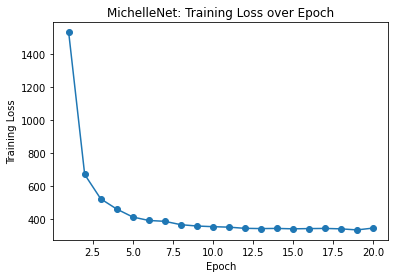

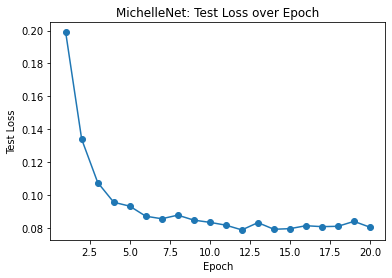

In [520]:
test(my_aug_better_model, train_loader, subset_indices_valid) 
test(my_aug_better_model, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = my_aug_better_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("MichelleNet: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = my_aug_better_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("MichelleNet: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

# One half

In [571]:
train_indices = [i[0] for i in enumerate(train_loader)]
s = int(0.5 * len(train_indices))
selected_indicies = np.random.choice(train_indices, size=s)

In [572]:

def ce_train(model,train_loader, optimizer, epoch, log_interval, selected_indices):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx not in selected_indices:
            continue
        data, target = data, target
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = nn.CrossEntropyLoss()
        
        output_loss = loss(output, target)   # Compute loss
        total_loss += output_loss.item()
        
        output_loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), output_loss))
    return total_loss


def ce_test(model, test_loader, subset_indices_valid):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_loss_ce = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            ce_loss = nn.CrossEntropyLoss()
            output_loss = ce_loss(output, target) 
            test_loss_ce += output_loss

    test_loss /= len(test_loader.dataset)
    
    total = len(subset_indices_valid)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    test_loss_nll = test_loss
    
    return test_loss_nll, test_loss_ce, correct, total



In [575]:
# train_indices = [i[0] for i in enumerate(train_loader)]
# s = int(0.5 * len(train_indices))
# selected_indicies = np.random.choice(train_indices, size=s)

# Load your model [fcNet, ConvNet, Net]
half = MyConvNet()
epochs = 15

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(half.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

half_model_training_errors = []
half_model_nll_test_errors = []
half_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(half, aug_train_loader, optimizer, epoch, log_interval, selected_indicies)
    test_loss_nll, test_loss_ce, _, _ = ce_test(half, aug_val_loader, subset_indices_valid) 
    
    half_model_training_errors.append(train_loss)
    half_model_nll_test_errors.append(test_loss_nll)
    half_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(half.state_dict(), "mnist_model4_half.pt")
    
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.490955
Train Epoch: 1 [1280/60000 (3%)]	Loss: 2.376684
Train Epoch: 1 [4480/60000 (9%)]	Loss: 2.289582
Train Epoch: 1 [5120/60000 (10%)]	Loss: 2.220560
Train Epoch: 1 [6720/60000 (13%)]	Loss: 2.311633
Train Epoch: 1 [7680/60000 (15%)]	Loss: 2.251650
Train Epoch: 1 [9600/60000 (19%)]	Loss: 2.108470
Train Epoch: 1 [9920/60000 (19%)]	Loss: 2.052298
Train Epoch: 1 [10240/60000 (20%)]	Loss: 2.094595
Train Epoch: 1 [10560/60000 (21%)]	Loss: 1.909585
Train Epoch: 1 [11520/60000 (23%)]	Loss: 1.925550
Train Epoch: 1 [12160/60000 (24%)]	Loss: 1.780040
Train Epoch: 1 [13120/60000 (26%)]	Loss: 1.614314
Train Epoch: 1 [13440/60000 (26%)]	Loss: 1.728935
Train Epoch: 1 [14080/60000 (28%)]	Loss: 1.793134
Train Epoch: 1 [16000/60000 (31%)]	Loss: 1.815972
Train Epoch: 1 [16640/60000 (33%)]	Loss: 1.515091
Train Epoch: 1 [17920/60000 (35%)]	Loss: 1.407132
Train Epoch: 1 [18560/60000 (36%)]	Loss: 1.441641
Train Epoch: 1 [18880/60000 (37%)]	Loss: 1.504436
Train Epoch: 1

Train Epoch: 4 [1280/60000 (3%)]	Loss: 0.380989
Train Epoch: 4 [4480/60000 (9%)]	Loss: 0.713485
Train Epoch: 4 [5120/60000 (10%)]	Loss: 0.709021
Train Epoch: 4 [6720/60000 (13%)]	Loss: 0.528895
Train Epoch: 4 [7680/60000 (15%)]	Loss: 0.455303
Train Epoch: 4 [9600/60000 (19%)]	Loss: 0.343336
Train Epoch: 4 [9920/60000 (19%)]	Loss: 0.506942
Train Epoch: 4 [10240/60000 (20%)]	Loss: 0.508701
Train Epoch: 4 [10560/60000 (21%)]	Loss: 0.513647
Train Epoch: 4 [11520/60000 (23%)]	Loss: 0.401429
Train Epoch: 4 [12160/60000 (24%)]	Loss: 0.680178
Train Epoch: 4 [13120/60000 (26%)]	Loss: 0.345953
Train Epoch: 4 [13440/60000 (26%)]	Loss: 0.889850
Train Epoch: 4 [14080/60000 (28%)]	Loss: 0.465928
Train Epoch: 4 [16000/60000 (31%)]	Loss: 0.584541
Train Epoch: 4 [16640/60000 (33%)]	Loss: 0.355040
Train Epoch: 4 [17920/60000 (35%)]	Loss: 0.810116
Train Epoch: 4 [18560/60000 (36%)]	Loss: 0.540969
Train Epoch: 4 [18880/60000 (37%)]	Loss: 0.329538
Train Epoch: 4 [22400/60000 (44%)]	Loss: 0.620218
Train Epo

Train Epoch: 7 [1280/60000 (3%)]	Loss: 0.424753
Train Epoch: 7 [4480/60000 (9%)]	Loss: 0.397683
Train Epoch: 7 [5120/60000 (10%)]	Loss: 0.106491
Train Epoch: 7 [6720/60000 (13%)]	Loss: 0.180633
Train Epoch: 7 [7680/60000 (15%)]	Loss: 0.242809
Train Epoch: 7 [9600/60000 (19%)]	Loss: 0.503587
Train Epoch: 7 [9920/60000 (19%)]	Loss: 0.195970
Train Epoch: 7 [10240/60000 (20%)]	Loss: 0.453410
Train Epoch: 7 [10560/60000 (21%)]	Loss: 0.503656
Train Epoch: 7 [11520/60000 (23%)]	Loss: 0.504099
Train Epoch: 7 [12160/60000 (24%)]	Loss: 0.211739
Train Epoch: 7 [13120/60000 (26%)]	Loss: 0.384818
Train Epoch: 7 [13440/60000 (26%)]	Loss: 0.257680
Train Epoch: 7 [14080/60000 (28%)]	Loss: 0.622591
Train Epoch: 7 [16000/60000 (31%)]	Loss: 0.358861
Train Epoch: 7 [16640/60000 (33%)]	Loss: 0.603241
Train Epoch: 7 [17920/60000 (35%)]	Loss: 0.516888
Train Epoch: 7 [18560/60000 (36%)]	Loss: 0.266772
Train Epoch: 7 [18880/60000 (37%)]	Loss: 0.288488
Train Epoch: 7 [22400/60000 (44%)]	Loss: 0.148655
Train Epo

Train Epoch: 10 [1280/60000 (3%)]	Loss: 0.578420
Train Epoch: 10 [4480/60000 (9%)]	Loss: 0.368924
Train Epoch: 10 [5120/60000 (10%)]	Loss: 0.457135
Train Epoch: 10 [6720/60000 (13%)]	Loss: 0.214629
Train Epoch: 10 [7680/60000 (15%)]	Loss: 0.388188
Train Epoch: 10 [9600/60000 (19%)]	Loss: 0.454297
Train Epoch: 10 [9920/60000 (19%)]	Loss: 0.455392
Train Epoch: 10 [10240/60000 (20%)]	Loss: 0.245980
Train Epoch: 10 [10560/60000 (21%)]	Loss: 0.381289
Train Epoch: 10 [11520/60000 (23%)]	Loss: 0.651713
Train Epoch: 10 [12160/60000 (24%)]	Loss: 0.252476
Train Epoch: 10 [13120/60000 (26%)]	Loss: 0.458207
Train Epoch: 10 [13440/60000 (26%)]	Loss: 0.206132
Train Epoch: 10 [14080/60000 (28%)]	Loss: 0.653514
Train Epoch: 10 [16000/60000 (31%)]	Loss: 0.291533
Train Epoch: 10 [16640/60000 (33%)]	Loss: 0.342161
Train Epoch: 10 [17920/60000 (35%)]	Loss: 0.476544
Train Epoch: 10 [18560/60000 (36%)]	Loss: 0.130247
Train Epoch: 10 [18880/60000 (37%)]	Loss: 0.132058
Train Epoch: 10 [22400/60000 (44%)]	Loss

Train Epoch: 12 [48960/60000 (96%)]	Loss: 0.409525
Train Epoch: 12 [49600/60000 (97%)]	Loss: 0.254363

Test set: Average loss: 0.1378, Accuracy: 54171/113123 (48%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.295534
Train Epoch: 13 [1280/60000 (3%)]	Loss: 0.470340
Train Epoch: 13 [4480/60000 (9%)]	Loss: 0.375658
Train Epoch: 13 [5120/60000 (10%)]	Loss: 0.281461
Train Epoch: 13 [6720/60000 (13%)]	Loss: 0.222022
Train Epoch: 13 [7680/60000 (15%)]	Loss: 0.143881
Train Epoch: 13 [9600/60000 (19%)]	Loss: 0.617665
Train Epoch: 13 [9920/60000 (19%)]	Loss: 0.602827
Train Epoch: 13 [10240/60000 (20%)]	Loss: 0.280216
Train Epoch: 13 [10560/60000 (21%)]	Loss: 0.237023
Train Epoch: 13 [11520/60000 (23%)]	Loss: 0.381867
Train Epoch: 13 [12160/60000 (24%)]	Loss: 0.486430
Train Epoch: 13 [13120/60000 (26%)]	Loss: 0.581496
Train Epoch: 13 [13440/60000 (26%)]	Loss: 0.281968
Train Epoch: 13 [14080/60000 (28%)]	Loss: 0.160777
Train Epoch: 13 [16000/60000 (31%)]	Loss: 0.274039
Train Epoch: 13 [16640/60000 (33%

Train Epoch: 15 [47360/60000 (93%)]	Loss: 0.449970
Train Epoch: 15 [47680/60000 (93%)]	Loss: 0.411032
Train Epoch: 15 [48000/60000 (94%)]	Loss: 0.449403
Train Epoch: 15 [48320/60000 (95%)]	Loss: 0.448968
Train Epoch: 15 [48960/60000 (96%)]	Loss: 0.371865
Train Epoch: 15 [49600/60000 (97%)]	Loss: 0.374419

Test set: Average loss: 0.1323, Accuracy: 54258/113123 (48%)




Test set: Average loss: 0.1006, Accuracy: 49148/60000 (82%)


Test set: Average loss: 0.1050, Accuracy: 9674/10000 (97%)



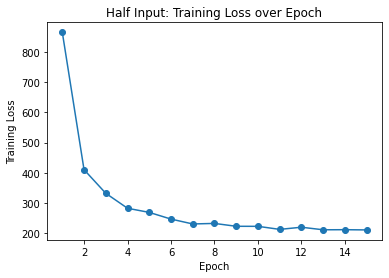

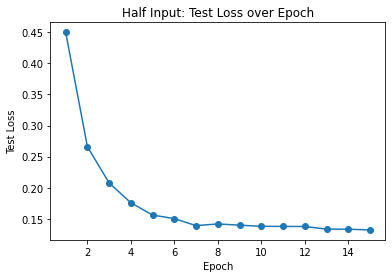

In [579]:
test(half, train_loader, subset_indices_valid) 
test(half, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = half_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Half Input: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = half_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Half Input: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

# One quarter

In [576]:
# train_indices = [i[0] for i in enumerate(train_loader)]
s = int(0.25 * len(train_indices))
selected_indicies = np.random.choice(train_indices, size=s)

# Load your model [fcNet, ConvNet, Net]
quarter = MyConvNet()
epochs = 15

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(quarter.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

quarter_model_training_errors = []
quarter_model_nll_test_errors = []
quarter_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(quarter, aug_train_loader, optimizer, epoch, log_interval, selected_indicies)
    test_loss_nll, test_loss_ce, _, _ = ce_test(quarter, aug_val_loader, subset_indices_valid) 
    
    quarter_model_training_errors.append(train_loss)
    quarter_model_nll_test_errors.append(test_loss_nll)
    quarter_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(quarter.state_dict(), "mnist_model4_quarter.pt")
    
    

Train Epoch: 1 [1280/60000 (3%)]	Loss: 2.417851
Train Epoch: 1 [4160/60000 (8%)]	Loss: 2.293157
Train Epoch: 1 [5440/60000 (11%)]	Loss: 2.277539
Train Epoch: 1 [5760/60000 (11%)]	Loss: 2.005329
Train Epoch: 1 [7360/60000 (14%)]	Loss: 2.232137
Train Epoch: 1 [10240/60000 (20%)]	Loss: 2.190195
Train Epoch: 1 [15040/60000 (29%)]	Loss: 2.092301
Train Epoch: 1 [15360/60000 (30%)]	Loss: 2.172165
Train Epoch: 1 [16640/60000 (33%)]	Loss: 1.934268
Train Epoch: 1 [17920/60000 (35%)]	Loss: 2.078759
Train Epoch: 1 [18240/60000 (36%)]	Loss: 2.138056
Train Epoch: 1 [21760/60000 (43%)]	Loss: 1.926564
Train Epoch: 1 [22720/60000 (45%)]	Loss: 1.694243
Train Epoch: 1 [24320/60000 (48%)]	Loss: 1.652830
Train Epoch: 1 [26240/60000 (51%)]	Loss: 1.931517
Train Epoch: 1 [28160/60000 (55%)]	Loss: 1.616665
Train Epoch: 1 [32000/60000 (63%)]	Loss: 1.863802
Train Epoch: 1 [33920/60000 (66%)]	Loss: 1.393865
Train Epoch: 1 [34240/60000 (67%)]	Loss: 1.329984
Train Epoch: 1 [37120/60000 (73%)]	Loss: 1.368419
Train E

Train Epoch: 7 [16640/60000 (33%)]	Loss: 0.372439
Train Epoch: 7 [17920/60000 (35%)]	Loss: 0.476430
Train Epoch: 7 [18240/60000 (36%)]	Loss: 0.868391
Train Epoch: 7 [21760/60000 (43%)]	Loss: 0.542394
Train Epoch: 7 [22720/60000 (45%)]	Loss: 0.428881
Train Epoch: 7 [24320/60000 (48%)]	Loss: 0.410047
Train Epoch: 7 [26240/60000 (51%)]	Loss: 0.386017
Train Epoch: 7 [28160/60000 (55%)]	Loss: 0.388275
Train Epoch: 7 [32000/60000 (63%)]	Loss: 0.498101
Train Epoch: 7 [33920/60000 (66%)]	Loss: 0.538226
Train Epoch: 7 [34240/60000 (67%)]	Loss: 0.290869
Train Epoch: 7 [37120/60000 (73%)]	Loss: 0.302506
Train Epoch: 7 [41280/60000 (81%)]	Loss: 0.247286
Train Epoch: 7 [46080/60000 (90%)]	Loss: 0.523698
Train Epoch: 7 [47040/60000 (92%)]	Loss: 0.731261
Train Epoch: 7 [47360/60000 (93%)]	Loss: 0.291296
Train Epoch: 7 [50560/60000 (99%)]	Loss: 0.395912

Test set: Average loss: 0.1925, Accuracy: 53162/113123 (47%)

Train Epoch: 8 [1280/60000 (3%)]	Loss: 0.496867
Train Epoch: 8 [4160/60000 (8%)]	Loss: 

Train Epoch: 13 [26240/60000 (51%)]	Loss: 0.396196
Train Epoch: 13 [28160/60000 (55%)]	Loss: 0.461728
Train Epoch: 13 [32000/60000 (63%)]	Loss: 0.571883
Train Epoch: 13 [33920/60000 (66%)]	Loss: 0.661505
Train Epoch: 13 [34240/60000 (67%)]	Loss: 0.447878
Train Epoch: 13 [37120/60000 (73%)]	Loss: 0.374144
Train Epoch: 13 [41280/60000 (81%)]	Loss: 0.399733
Train Epoch: 13 [46080/60000 (90%)]	Loss: 0.245035
Train Epoch: 13 [47040/60000 (92%)]	Loss: 0.210771
Train Epoch: 13 [47360/60000 (93%)]	Loss: 0.530529
Train Epoch: 13 [50560/60000 (99%)]	Loss: 0.290882

Test set: Average loss: 0.1714, Accuracy: 53568/113123 (47%)

Train Epoch: 14 [1280/60000 (3%)]	Loss: 0.394925
Train Epoch: 14 [4160/60000 (8%)]	Loss: 0.192837
Train Epoch: 14 [5440/60000 (11%)]	Loss: 0.530031
Train Epoch: 14 [5760/60000 (11%)]	Loss: 0.661238
Train Epoch: 14 [7360/60000 (14%)]	Loss: 0.307422
Train Epoch: 14 [10240/60000 (20%)]	Loss: 0.298126
Train Epoch: 14 [15040/60000 (29%)]	Loss: 0.357128
Train Epoch: 14 [15360/600


Test set: Average loss: 0.1351, Accuracy: 48610/60000 (81%)


Test set: Average loss: 0.1426, Accuracy: 9560/10000 (96%)



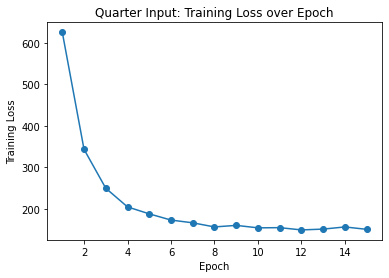

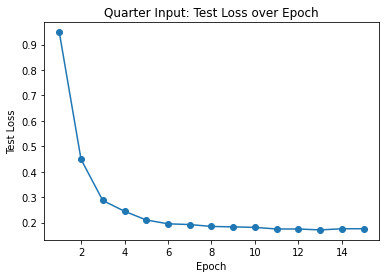

In [580]:
test(quarter, train_loader, subset_indices_valid) 
test(quarter, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = quarter_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Quarter Input: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = quarter_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Quarter Input: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

# One eighth

In [577]:
# train_indices = [i[0] for i in enumerate(train_loader)]
s = int(0.125 * len(train_indices))
selected_indicies = np.random.choice(train_indices, size=s)

# Load your model [fcNet, ConvNet, Net]
eighth = MyConvNet()
epochs = 15

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(eighth.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

eighth_model_training_errors = []
eighth_model_nll_test_errors = []
eighth_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(eighth, aug_train_loader, optimizer, epoch, log_interval, selected_indicies)
    test_loss_nll, test_loss_ce, _, _ = ce_test(eighth, aug_val_loader, subset_indices_valid) 
    
    eighth_model_training_errors.append(train_loss)
    eighth_model_nll_test_errors.append(test_loss_nll)
    eighth_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(eighth.state_dict(), "mnist_model4_eighth.pt")
    
    

Train Epoch: 1 [1280/60000 (3%)]	Loss: 2.451506
Train Epoch: 1 [2560/60000 (5%)]	Loss: 2.435684
Train Epoch: 1 [3200/60000 (6%)]	Loss: 2.502823
Train Epoch: 1 [8960/60000 (18%)]	Loss: 2.378975
Train Epoch: 1 [9280/60000 (18%)]	Loss: 2.298870
Train Epoch: 1 [9600/60000 (19%)]	Loss: 2.352304
Train Epoch: 1 [10560/60000 (21%)]	Loss: 2.374168
Train Epoch: 1 [17920/60000 (35%)]	Loss: 2.164435
Train Epoch: 1 [20800/60000 (41%)]	Loss: 2.327309
Train Epoch: 1 [21440/60000 (42%)]	Loss: 2.267840
Train Epoch: 1 [22400/60000 (44%)]	Loss: 2.072366
Train Epoch: 1 [27840/60000 (55%)]	Loss: 2.217523
Train Epoch: 1 [29120/60000 (57%)]	Loss: 2.117131
Train Epoch: 1 [30080/60000 (59%)]	Loss: 2.236986
Train Epoch: 1 [34560/60000 (68%)]	Loss: 1.967750
Train Epoch: 1 [40640/60000 (80%)]	Loss: 2.043635
Train Epoch: 1 [44800/60000 (88%)]	Loss: 2.009183
Train Epoch: 1 [45760/60000 (90%)]	Loss: 1.740355

Test set: Average loss: 1.6269, Accuracy: 19907/113123 (18%)

Train Epoch: 2 [1280/60000 (3%)]	Loss: 1.83487

Train Epoch: 9 [29120/60000 (57%)]	Loss: 0.981997
Train Epoch: 9 [30080/60000 (59%)]	Loss: 0.839288
Train Epoch: 9 [34560/60000 (68%)]	Loss: 0.920885
Train Epoch: 9 [40640/60000 (80%)]	Loss: 0.724994
Train Epoch: 9 [44800/60000 (88%)]	Loss: 0.583819
Train Epoch: 9 [45760/60000 (90%)]	Loss: 0.936695

Test set: Average loss: 0.5164, Accuracy: 48633/113123 (43%)

Train Epoch: 10 [1280/60000 (3%)]	Loss: 0.831124
Train Epoch: 10 [2560/60000 (5%)]	Loss: 0.867291
Train Epoch: 10 [3200/60000 (6%)]	Loss: 0.690723
Train Epoch: 10 [8960/60000 (18%)]	Loss: 0.782185
Train Epoch: 10 [9280/60000 (18%)]	Loss: 0.706653
Train Epoch: 10 [9600/60000 (19%)]	Loss: 0.925262
Train Epoch: 10 [10560/60000 (21%)]	Loss: 0.641065
Train Epoch: 10 [17920/60000 (35%)]	Loss: 0.740513
Train Epoch: 10 [20800/60000 (41%)]	Loss: 0.955768
Train Epoch: 10 [21440/60000 (42%)]	Loss: 0.694160
Train Epoch: 10 [22400/60000 (44%)]	Loss: 0.750516
Train Epoch: 10 [27840/60000 (55%)]	Loss: 0.741715
Train Epoch: 10 [29120/60000 (57%)


Test set: Average loss: 0.4020, Accuracy: 45020/60000 (75%)


Test set: Average loss: 0.4559, Accuracy: 8902/10000 (89%)



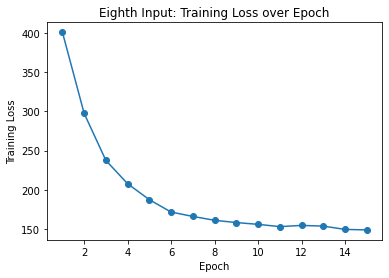

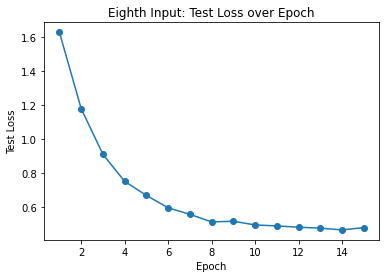

In [581]:
test(eighth, train_loader, subset_indices_valid) 
test(eighth, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = eighth_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Eighth Input: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = eighth_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Eighth Input: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

# One sixteenth

In [578]:
# train_indices = [i[0] for i in enumerate(train_loader)]
s = int(0.0625 * len(train_indices))
selected_indicies = np.random.choice(train_indices, size=s)

# Load your model [fcNet, ConvNet, Net]
sixteen = MyConvNet()
epochs = 15

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(sixteen.parameters(), lr=0.001)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

sixteen_model_training_errors = []
sixteen_model_nll_test_errors = []
sixteen_model_ce_test_errors = []

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = ce_train(sixteen, aug_train_loader, optimizer, epoch, log_interval, selected_indicies)
    test_loss_nll, test_loss_ce, _, _ = ce_test(sixteen, aug_val_loader, subset_indices_valid) 
    
    sixteen_model_training_errors.append(train_loss)
    sixteen_model_nll_test_errors.append(test_loss_nll)
    sixteen_model_ce_test_errors.append(test_loss_ce)
    
    scheduler.step()    # learning rate scheduler

    # You may optionally save your model at each epoch here

if save_model:
    torch.save(sixteen.state_dict(), "mnist_model4_sixteen.pt")
    
    

Train Epoch: 1 [6720/60000 (13%)]	Loss: 2.336639
Train Epoch: 1 [8320/60000 (16%)]	Loss: 2.407300
Train Epoch: 1 [15680/60000 (31%)]	Loss: 2.289188
Train Epoch: 1 [24000/60000 (47%)]	Loss: 2.174955
Train Epoch: 1 [29120/60000 (57%)]	Loss: 2.225210
Train Epoch: 1 [32320/60000 (63%)]	Loss: 2.334201
Train Epoch: 1 [36160/60000 (71%)]	Loss: 2.267546
Train Epoch: 1 [38720/60000 (76%)]	Loss: 2.268146
Train Epoch: 1 [41600/60000 (82%)]	Loss: 2.319842
Train Epoch: 1 [41920/60000 (82%)]	Loss: 2.183742
Train Epoch: 1 [45440/60000 (89%)]	Loss: 2.273956
Train Epoch: 1 [45760/60000 (90%)]	Loss: 2.286930
Train Epoch: 1 [46080/60000 (90%)]	Loss: 2.211510

Test set: Average loss: 1.9835, Accuracy: 10858/113123 (10%)

Train Epoch: 2 [6720/60000 (13%)]	Loss: 2.184257
Train Epoch: 2 [8320/60000 (16%)]	Loss: 2.234711
Train Epoch: 2 [15680/60000 (31%)]	Loss: 2.114193
Train Epoch: 2 [24000/60000 (47%)]	Loss: 2.005559
Train Epoch: 2 [29120/60000 (57%)]	Loss: 1.939011
Train Epoch: 2 [32320/60000 (63%)]	Loss: 

Train Epoch: 12 [38720/60000 (76%)]	Loss: 1.268230
Train Epoch: 12 [41600/60000 (82%)]	Loss: 1.208593
Train Epoch: 12 [41920/60000 (82%)]	Loss: 1.175779
Train Epoch: 12 [45440/60000 (89%)]	Loss: 1.347168
Train Epoch: 12 [45760/60000 (90%)]	Loss: 1.076779
Train Epoch: 12 [46080/60000 (90%)]	Loss: 1.315644

Test set: Average loss: 1.0635, Accuracy: 37647/113123 (33%)

Train Epoch: 13 [6720/60000 (13%)]	Loss: 1.321197
Train Epoch: 13 [8320/60000 (16%)]	Loss: 1.122586
Train Epoch: 13 [15680/60000 (31%)]	Loss: 1.413065
Train Epoch: 13 [24000/60000 (47%)]	Loss: 1.433433
Train Epoch: 13 [29120/60000 (57%)]	Loss: 1.140170
Train Epoch: 13 [32320/60000 (63%)]	Loss: 1.352549
Train Epoch: 13 [36160/60000 (71%)]	Loss: 1.350295
Train Epoch: 13 [38720/60000 (76%)]	Loss: 1.463897
Train Epoch: 13 [41600/60000 (82%)]	Loss: 1.222798
Train Epoch: 13 [41920/60000 (82%)]	Loss: 1.412522
Train Epoch: 13 [45440/60000 (89%)]	Loss: 0.941430
Train Epoch: 13 [45760/60000 (90%)]	Loss: 1.119916
Train Epoch: 13 [4608


Test set: Average loss: 0.9592, Accuracy: 33276/60000 (55%)


Test set: Average loss: 1.1196, Accuracy: 6586/10000 (66%)



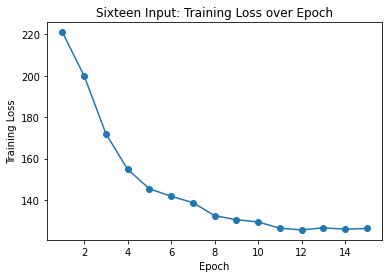

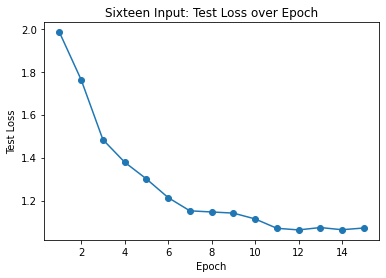

In [582]:
test(sixteen, train_loader, subset_indices_valid) 
test(sixteen, test_loader, subset_indices_valid) 

x = list(range(1, epochs + 1))
y = sixteen_model_training_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Sixteen Input: Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

x = list(range(1, epochs + 1))
y = sixteen_model_nll_test_errors
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Sixteen Input: Test Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

## When you have finished tweaking your network:

In [523]:
test(aug_model, train_loader, range(len(train_dataset))) 


Test set: Average loss: 0.0322, Accuracy: 50410/60000 (84%)



(0.03216324483621866, 50410, 60000)

In [528]:
test(aug_model, aug_all_train_loader, range(len(aug_all_train_loader))) 


Test set: Average loss: 0.0522, Accuracy: 59038/60000 (98%)



(0.05221031327171562, 59038, 60000)

In [524]:
test(aug_model, test_loader, range(len(test_dataset))) 


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (99%)



(0.03403181433582245, 9893, 10000)

In [527]:
torch.save(aug_model.state_dict(), "mnist_model4_aug.pt")



## Analyze what your network has learned.


In [296]:
# def test(model, test_loader, subset_indices_valid):
incorrect_images = []
true_incorrect_labels = []
pred_incorrect_labels = []

incorrect_count = 0
correct_count = 0


aug_model.eval()    # Set the model to inference mode
test_loss = 0
correct = 0
with torch.no_grad():   # For the inference step, gradient is not computed
    for data, target in test_loader:
        data, target = data, target
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        for p in range(len(pred)):
            if pred[p] != target[p]:
                incorrect_count += 1
                incorrect_images.append(data[p])
                true_incorrect_labels.append(target[p])
                pred_incorrect_labels.append(pred[p])
            else:
                correct_count += 1
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

total = len(subset_indices_valid)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, total,
    100. * correct / total))

#     return test_loss, correct, total


Test set: Average loss: 0.0340, Accuracy: 9893/116561 (8%)



In [289]:
# incorrect_images = []
print(incorrect_count)
print(correct_count)

107
9893


Present at least 9 examples from the test set where your classifier made a mistake. (1 point) Present them in a 3x3 grid in your report. Discuss what you see. 


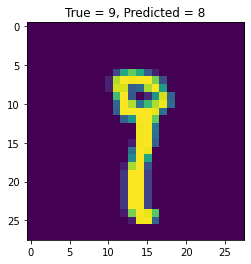

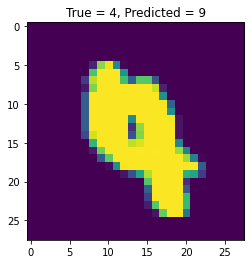

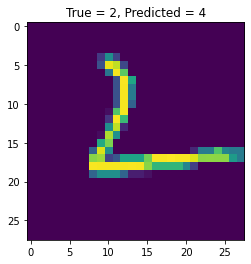

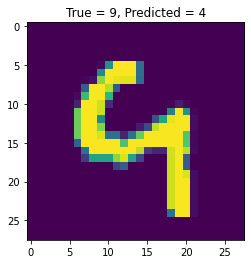

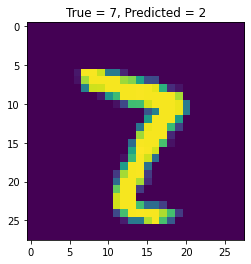

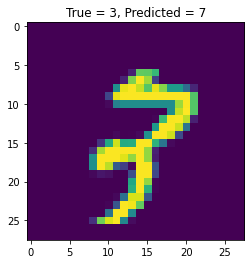

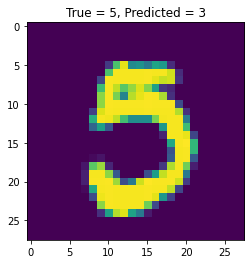

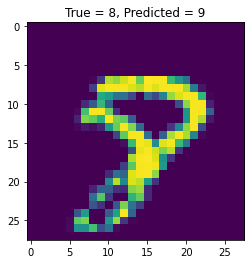

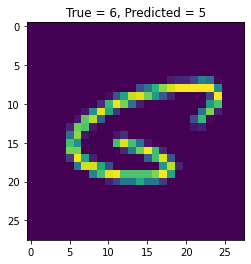

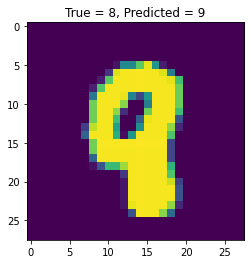

In [300]:
for i in range(0, 10):
    img = incorrect_images[i]
    plt.imshow(img[0, :, :])
    plt.title("True = "+str(true_incorrect_labels[i].item()) +
             ", Predicted = "+str(pred_incorrect_labels[i].item()))
    plt.show()
    

Visualize at least 9 of the learned kernels from the first layer of your network. (1 point) Present them in a 3x3 grid in your report. Discuss what you see. 


In [306]:
count_params = 0
for param in aug_model.parameters():
    count_params += 1
#     print(param.data)

In [307]:
count_params

14

In [316]:
conv1_weights = aug_model.conv1.weight.data
conv2_weights = aug_model.conv2.weight.data
conv3_weights = aug_model.conv3.weight.data

In [319]:
kernel_display = []
for i in range(10):
    kernel_conv1 = conv1_weights[i,0,:,:]
    kernel_display.append(kernel_conv1)


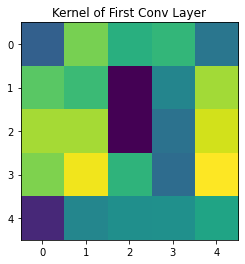

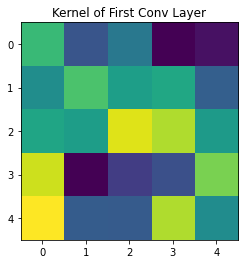

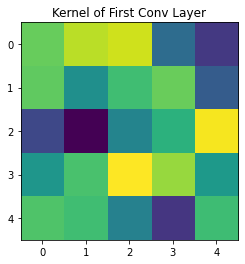

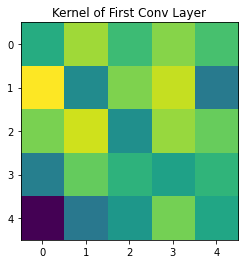

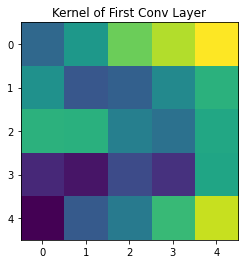

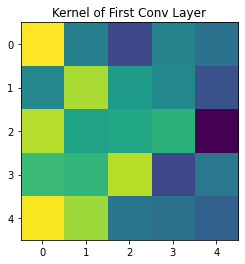

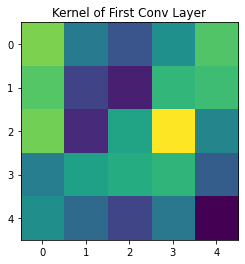

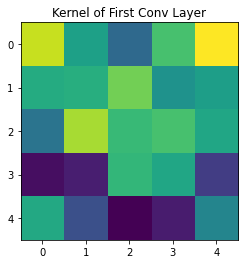

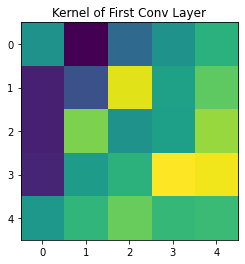

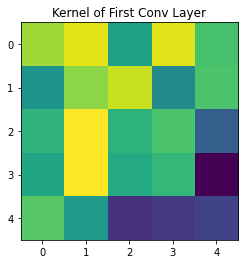

In [320]:
for i in range(0, 10):
    img = kernel_display[i]
    plt.imshow(img)
    plt.title("Kernel of First Conv Layer")
    plt.show()
    

Use your network to convert each image in the test set into a feature vector (taken from just before the final linear layer). 
Visualize this high-dimensional embedding in 2D using tSNE (each class should have its own color). (1 point) Discuss what you see.


In [325]:
def forward_process(model, x):
#     print(x.shape)
    x = model.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = model.dropout1(x)
#         print(x.shape)

    x = model.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 4)
    x = model.dropout2(x)
#         print(x.shape)
#         print(x)

    x = model.conv3(x)
    x = F.relu(x)
    x = F.avg_pool2d(x, 2)
    x = model.dropout2(x)
#         print(x.shape)

    x = model.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = model.dropout2(x)
#         print(x.shape)

    x = torch.flatten(x, 1)
#         print(x.shape)
    x = model.fc1(x)
    x = model.bn1(x)

    x = F.relu(x)
    return x

In [328]:
# def test(model, test_loader, subset_indices_valid):
embedding_info = []
targets = []


aug_model.eval()    # Set the model to inference mode
test_loss = 0
correct = 0
with torch.no_grad():   # For the inference step, gradient is not computed
    for data, target in test_loader:
        data, target = data, target
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         print(data.shape)
#         print(len(pred))

        emb = forward_process(aug_model, data)
        embedding_info.append(emb)
        targets.append(target[0])
        
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

total = len(subset_indices_valid)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, total,
    100. * correct / total))

#     return test_loss, correct, total


Test set: Average loss: 0.0340, Accuracy: 9893/116561 (8%)



In [338]:
len(embedding_info)

10000

In [342]:
embedding_info2 = torch.cat(embedding_info, axis=0)

In [343]:
embedding_info2.shape

torch.Size([10000, 96])

In [347]:
test_tsne = TSNE(random_state=123).fit_transform(embedding_info2)

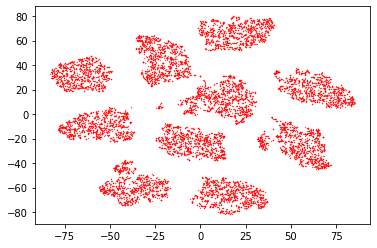

In [355]:
# Y = test_tsne.fit_transform(embedding_info2)
Y = test_tsne
# ax.set_title("Perplexity=%d" % perplexity)
plt.scatter(Y[:, 0], Y[:, 1], s=0.1, cmap='viridis', c='r')


plt.show()

(980, 2)
(1135, 2)
(1032, 2)
(1010, 2)
(982, 2)
(892, 2)
(958, 2)
(1028, 2)
(974, 2)
(1009, 2)


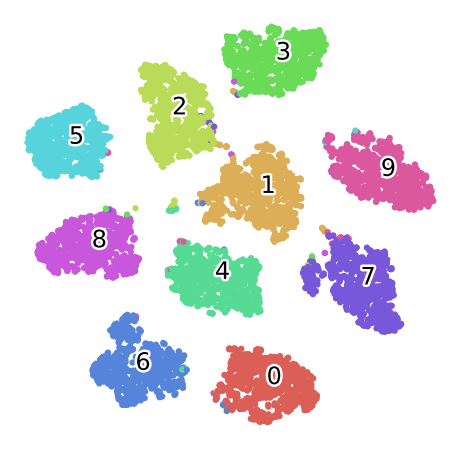

In [383]:
x = test_tsne
colors = np.array(targets)

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.
    print(x[colors == i, :].shape)
    xtext, ytext = np.median(x[colors == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txt.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground="w"),
        path_effects.Normal()])
    txts.append(txt)


Choose one image I0 with feature vector x0 from the test set. Find the 8 images I1, I2, …, I8 in the test set whose feature vectors are closest in Euclidean distance to x0. Repeat this process for at least 3 more choices of I0. (1 point) Present your results in an nx8 grid of images (where n is at least 4). Discuss what you see. 


In [384]:
def euclidean(x, y):
    distance = 0
    for i in range(len(x)):
        distance += ((x[i]-y[i])**2)
    return np.sqrt(distance)

In [385]:
image0_choices = []
image0_targets = []
for data, target in test_loader:
    data, target = data, target
    image0_choices.append(data)
    image0_targets.append(target[0])
    if len(image0_choices) ==3:
        break

In [386]:
test_images_all = []
test_targets_all = []
for data, target in test_loader:
    data, target = data, target
    test_images_all.append(data[0])
    test_targets_all.append(target[0])

In [394]:
# for i in range(len(image0_choices)):
emb_img0 = embedding_info[0][0]

distances = []
for j in range(len(embedding_info)):
#     if i == j:
#         continue
    check_emb = embedding_info[j][0]
    dist = euclidean(emb_img0, check_emb)
    distances.append(dist)

In [416]:
k = 9
distances_to_img0 = np.array(distances)
idx = np.argsort(distances_to_img0)[:k]

# idx = np.argpartition(distances_to_img0, k)
print(idx[:3])

[   0  754 5800]


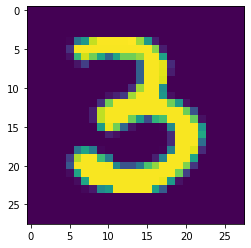

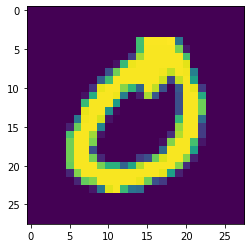

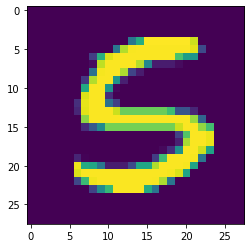

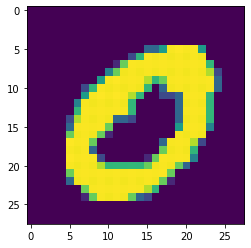

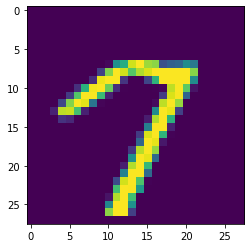

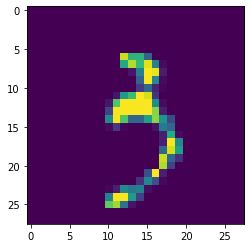

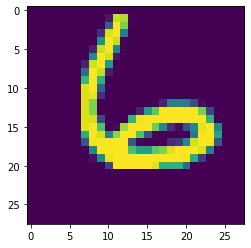

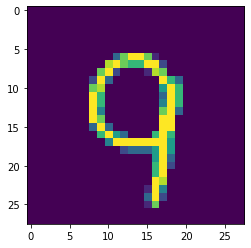

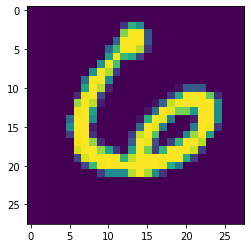

In [418]:
plt.imshow(test_images_all[0][0,:,:])
plt.show()

for index in idx[1:]:
    plt.imshow(test_images_all[index][0,:,:])
    plt.show()


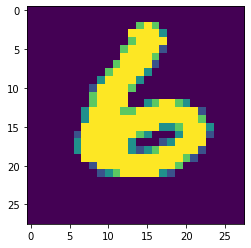

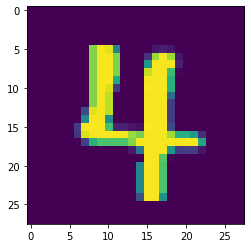

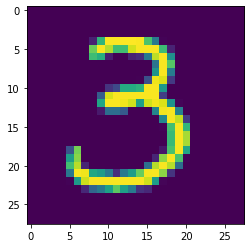

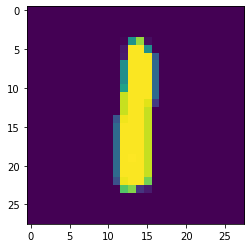

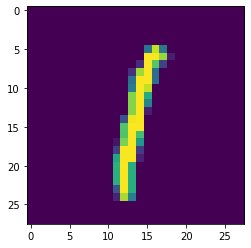

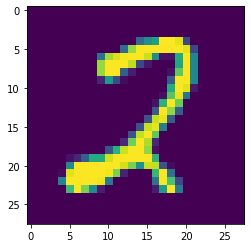

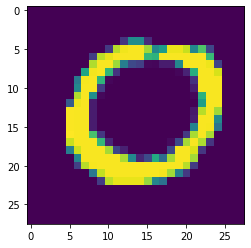

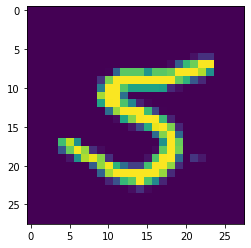

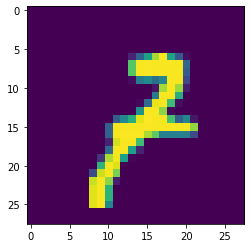

In [419]:
# for i in range(len(image0_choices)):
emb_img0 = embedding_info[1][0]

distances = []
for j in range(len(embedding_info)):
#     if i == j:
#         continue
    check_emb = embedding_info[j][0]
    dist = euclidean(emb_img0, check_emb)
    distances.append(dist)
    
k = 10
distances_to_img0 = np.array(distances)
idx = np.argsort(distances_to_img0)[:k]
plt.imshow(test_images_all[1][0,:,:])
plt.show()

for index in idx[2:]:
    plt.imshow(test_images_all[index][0,:,:])
    plt.show()


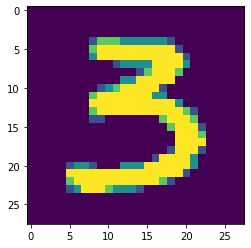

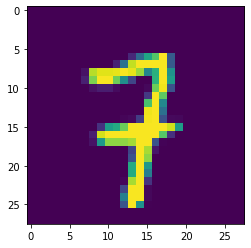

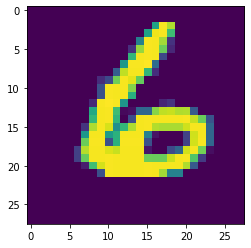

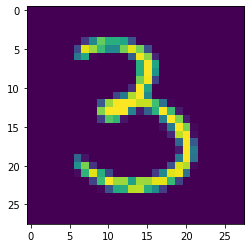

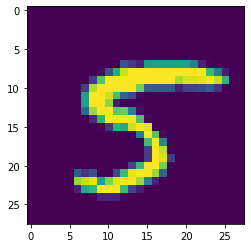

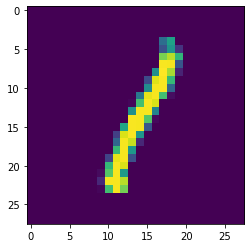

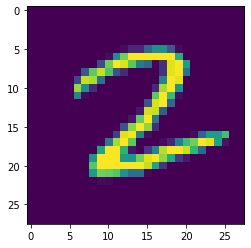

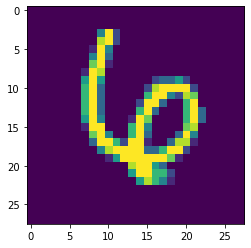

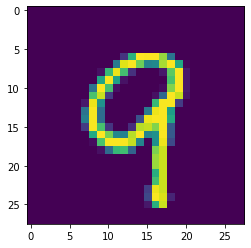

In [420]:
# for i in range(len(image0_choices)):
emb_img0 = embedding_info[2][0]

distances = []
for j in range(len(embedding_info)):
#     if i == j:
#         continue
    check_emb = embedding_info[j][0]
    dist = euclidean(emb_img0, check_emb)
    distances.append(dist)
    
k = 11
distances_to_img0 = np.array(distances)
idx = np.argsort(distances_to_img0)[:k]
plt.imshow(test_images_all[2][0,:,:])
plt.show()

for index in idx[3:]:
    plt.imshow(test_images_all[index][0,:,:])
    plt.show()


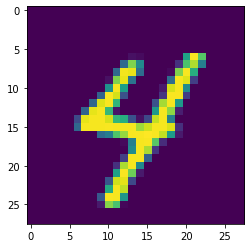

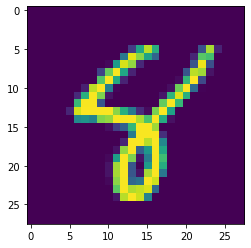

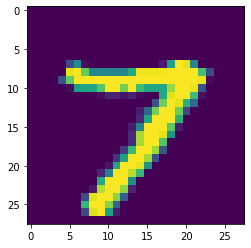

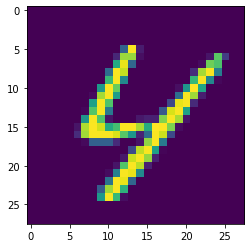

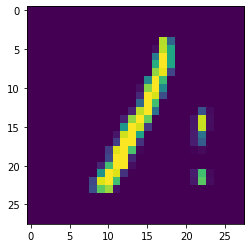

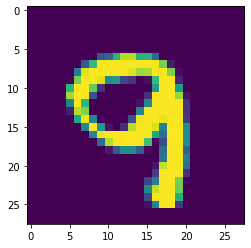

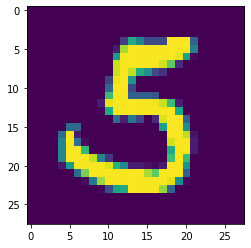

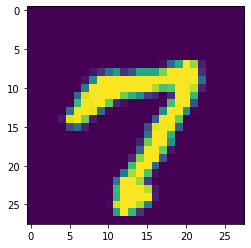

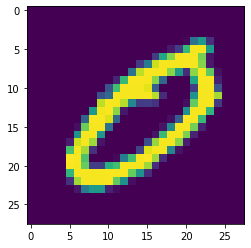

In [421]:
# for i in range(len(image0_choices)):
emb_img0 = embedding_info[3][0]

distances = []
for j in range(len(embedding_info)):
#     if i == j:
#         continue
    check_emb = embedding_info[j][0]
    dist = euclidean(emb_img0, check_emb)
    distances.append(dist)
    
k = 12
distances_to_img0 = np.array(distances)
idx = np.argsort(distances_to_img0)[:k]
plt.imshow(test_images_all[3][0,:,:])
plt.show()

for index in idx[4:]:
    plt.imshow(test_images_all[index][0,:,:])
    plt.show()


In [529]:
X_test = []
Y_test = []
for data, target in test_dataset:
    X_test.append(data)
    Y_test.append(target)

In [530]:
class_names = [str(i) for i in range(1, 11)]

In [545]:

aug_model.eval()    # Set the model to inference mode
Y_pred = []
with torch.no_grad():   # For the inference step, gradient is not computed
    for data, target in test_loader:
        data, target = data, target
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        Y_pred.append(pred[0])
        
        

In [546]:
len(Y_pred[0])

1

In [532]:
# from sklearn.metrics import plot_confusion_matrix

# disp = plot_confusion_matrix(classifier, X_test, y_test,
#                              display_labels=class_names,
#                              cmap=plt.cm.Blues,
#                              normalize=normalize)
# disp.ax_.set_title(title)

# print(title)
# print(disp.confusion_matrix)

In [560]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(Y_test), np.array(Y_pred), normalize=None)






In [566]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Normalized Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.1122449  0.09795918 0.10408163 0.10306122 0.09183673 0.09081633
  0.10612245 0.09693878 0.09897959 0.09795918]
 [0.09603524 0.11453744 0.11101322 0.0907489  0.09515419 0.08722467
  0.0907489  0.11453744 0.08370044 0.11629956]
 [0.09108527 0.11918605 0.11627907 0.09883721 0.09496124 0.08914729
  0.09689922 0.10465116 0.09689922 0.09205426]
 [0.11089109 0.12079208 0.11881188 0.1039604  0.0980198  0.09009901
  0.08712871 0.09108911 0.09009901 0.08910891]
 [0.10794297 0.10794297 0.08553971 0.09775967 0.098778   0.0814664
  0.09979633 0.11405295 0.11201629 0.09470468]
 [0.09529148 0.12331839 0.11659193 0.09865471 0.0896861  0.0896861
  0.10089686 0.09080717 0.10538117 0.0896861 ]
 [0.09707724 0.08350731 0.08872651 0.1085595  0.0960334  0.09498956
  0.11064718 0.11795407 0.11377871 0.08872651]
 [0.0885214  0.12548638 0.09338521 0.1118677  0.11478599 0.08268482
  0.09143969 0.09533074 0.09143969 0.10505837]
 [0.09137577 0.12628337 0.09856263 0.09445585 0.095482

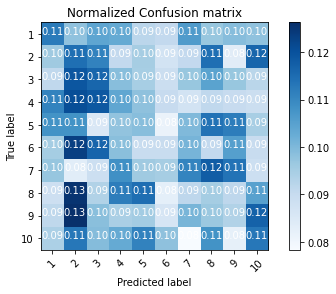

In [567]:
plot_confusion_matrix(cm, class_names, normalize=True)